In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Load the data
file_path = "SPY_section_2.csv"
df = pd.read_csv(file_path)

In [20]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
# Define LSTM model
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [22]:
# Define the target variable
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)
df = df.dropna()

In [23]:
# Adding SMA and EMA to the feature
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean() # Short-term SMA
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean() # Medium-term SMA
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean() # Long-term SMA

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [24]:
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]

train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(X_scaled.shape)

Train: 1194, Val: 256, Test: 247
(1707, 11)


In [25]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<span style="color: yellow; font-size: 40px;">Evaluating original LSTM</span>

In [26]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30


===== Evaluation Results =====
Test Loss: 28.6670
Test MAE: 4.1148
Average Error Percentage: 4.20%
Largest Error Percentage: 22.92%


<ipython-input-27-8beb1d49274d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
/u

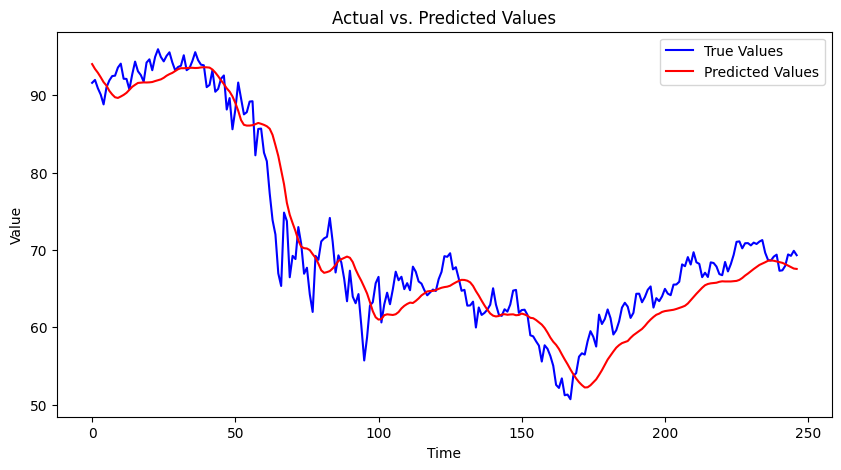

In [27]:
# Define paths
# LSTM_model_path = "./lstm_codes/lstm_models/lstm_section_2.pth"
LSTM_model_path = "lstm_section_2.pth"

# Load the trained model
LSTM_model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
LSTM_model.eval()

# Define loss function
criterion = torch.nn.MSELoss()

# Evaluate on test data
test_loss = 0.0
test_mae = 0.0
all_true = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = LSTM_model(X_batch)
        loss = criterion(outputs, y_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))

        test_loss += loss.item() * X_batch.size(0)
        test_mae += mae.item() * X_batch.size(0)

        all_true.extend(y_batch.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Compute final metrics
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

# Compute error percentages
all_true = np.array(all_true).flatten()
all_preds = np.array(all_preds).flatten()
error = np.abs(all_true - all_preds) / (np.abs(all_true) + 1e-8)
avg_error = np.mean(error) * 100
largest_error = np.max(error) * 100

# Print results
print("\n===== Evaluation Results =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Average Error Percentage: {avg_error:.2f}%")
print(f"Largest Error Percentage: {largest_error:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(all_true, label='True Values', color='blue')
plt.plot(all_preds, label='Predicted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


<span style="color: yellow; font-size: 40px;">Evaluating original autoencoder</span>

In [28]:
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

In [29]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [30]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [31]:
input_dim = X_train.shape[1]

# Hyperparameters
encoding_dim = 5
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 750
batch_size = 16
patience = 40

In [32]:
# autoencoder_model_path = "./autoencoder_codes/autoencoder_models/autoencoder_section_1.pth"
autoencoder_model_path = "autoencoder_section_2.pth"
autoencoder_model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate).to(device)
autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.device('cpu')))

<ipython-input-32-c9404250f7ba>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.devi

<All keys matched successfully>

In [33]:
autoencoder_model.eval()
with torch.no_grad():
    reconstructed_test = autoencoder_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
mse = np.mean((X_test - reconstructed_test) ** 2)
mae = np.mean(np.abs(X_test - reconstructed_test))
ree = np.mean(np.linalg.norm(X_test - reconstructed_test, axis=1) / np.linalg.norm(X_test, axis=1))
euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
average_error = np.mean(reconstruction_error_percentage)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, REE: {ree:.4f}, Euclidean Distance: {euclidean_dist:.4f}, Average Error: {average_error:.4f}%')

MSE: 0.0228, MAE: 0.0984, REE: 0.2287, Euclidean Distance: 0.4141, Average Error: 81.7411%


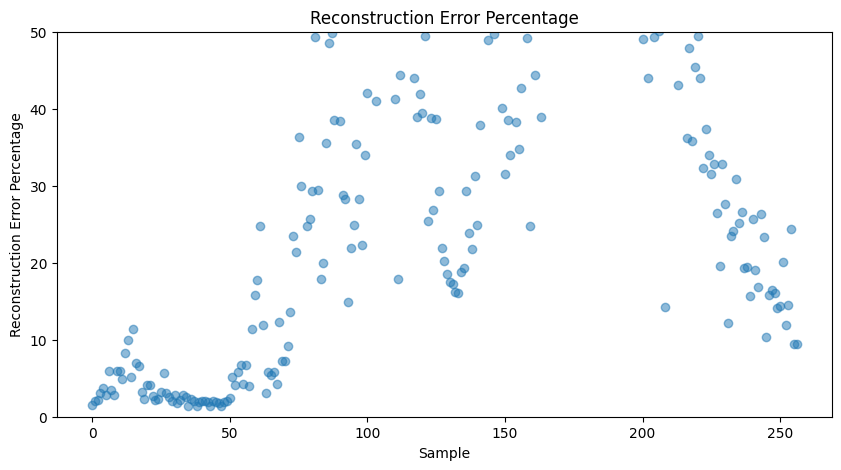

In [34]:
# Scatter plot of reconstruction error percentage
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, alpha=0.5)
plt.ylim(0, 50)
plt.xlabel('Sample')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage')
plt.show()


<span style="color: yellow; font-size: 40px;">Bias correction model - single input</span>

In [35]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size1, dropout_rate):
#         super(BiasPredictor, self).__init__()

#         hidden_size2 = hidden_size1 // 2
#         hidden_size3 = hidden_size2 // 2
#         hidden_size4 = hidden_size3 // 2  # New additional layer

#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, hidden_size4)  # New additional layer
#         self.dropout4 = nn.Dropout(dropout_rate)

#         self.fc5 = nn.Linear(hidden_size4, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         x = F.relu(self.fc4(x))  # New layer
#         x = self.dropout4(x)

#         return self.fc5(x)

##################################################################

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size, dropout_rate):
#         super(BiasPredictor, self).__init__()

#         # Calculate progressively halved hidden sizes
#         hidden_size2 = hidden_size // 2
#         hidden_size3 = hidden_size2 // 2

#         # Define layers
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_size, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         return self.fc4(x)  # Output layer without activation

##################################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(BiasPredictor, self).__init__()

        # Calculate progressively halved hidden sizes
        hidden_size2 = hidden_size // 2

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, 1)  # Final output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return self.fc3(x)  # Output layer without activation




In [36]:
# Get LSTM predictions of entire dataset
with torch.no_grad():
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
    LSTM_preds = LSTM_model(X_tensor).cpu().numpy()

# Put LSTM predictions into a new DataFrame
new_df = pd.DataFrame(LSTM_preds, columns=["LSTM_Pred"])


In [37]:
# Drop the first sequence_length rows
temp_y = y
temp_y = temp_y[sequence_length:]

# add the target variable to the new DataFrame
new_df["Target"] = temp_y.values

In [38]:
# Get reconstruction error percentage for the entire dataset
autoencoder_model.eval()
with torch.no_grad():
    reconstructed = autoencoder_model(torch.tensor(X_scaled.values, dtype=torch.float32).to(device)).cpu().numpy()

# Compute the MAE
reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed), axis=1)

# Compute the reconstruction error percentage
# reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed) / (np.abs(X_scaled.values) + 1e-8), axis=1) * 100
# reconstruction_error = np.mean((X_scaled.values - reconstructed) / ((X_scaled.values) + 1e-8), axis=1) * 100

# Drop the first sequence_length rows
reconstruction_error_new = reconstruction_error[sequence_length:]

# Add the reconstruction error to the new DataFrame
new_df["Reconstruction_error_single"] = reconstruction_error_new

# Get reconstruction error arr of past 10 days
reconstruction_error_arr = []
for i in range(sequence_length, len(reconstruction_error)):
    reconstruction_error_arr.append(reconstruction_error[i - sequence_length:i])


# Add the reconstruction error array to the new DataFrame
new_df["Reconstruction_error_arr"] = reconstruction_error_arr



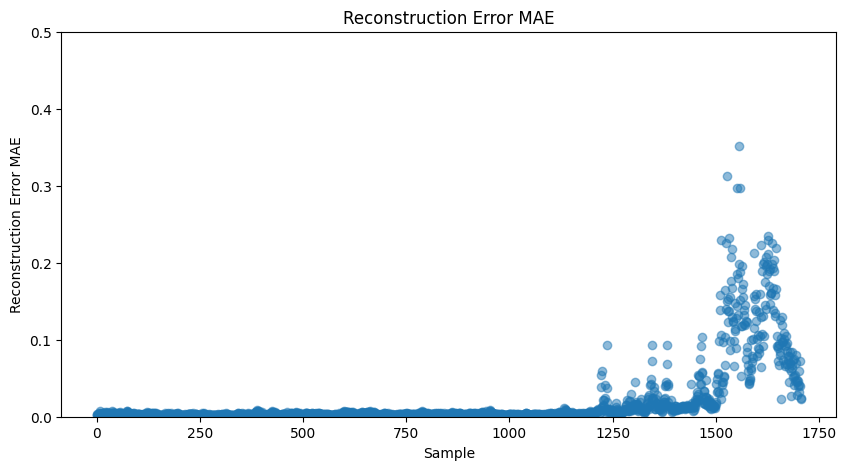

In [39]:
# plot reconstruction error scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, alpha=0.5)
plt.ylim(0, 0.5)
plt.xlabel('Sample')
# plt.ylabel('Reconstruction Error Percentage')
# plt.title('Reconstruction Error Percentage')
plt.ylabel('Reconstruction Error MAE')
plt.title('Reconstruction Error MAE')
plt.show()


In [40]:
reconstruction_error_arr[0]

array([0.00346786, 0.00279189, 0.00238325, 0.0025055 , 0.00360949,
       0.00329989, 0.00362503, 0.00512107, 0.00316199, 0.00687034])

In [41]:
# Calculate the difference between the target and LSTM prediction
new_df["Bias"] = new_df["Target"] - new_df["LSTM_Pred"]

In [42]:
y = new_df["Bias"]
X = new_df["Reconstruction_error_single"]
# X = new_df["Reconstruction_error_arr"]

In [43]:
# Sequential split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]
X_val_raw = X[train_size:train_size + val_size]
y_val_raw = y[train_size:train_size + val_size]
X_test_raw = X[train_size + val_size:]
y_test_raw = y[train_size + val_size:]

# Scale using StandardScaler (fit only on train data)
# X_scaler = StandardScaler()
X_scaler = RobustScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw.values.reshape(-1, 1))
X_val_scaled = X_scaler.transform(X_val_raw.values.reshape(-1, 1))
X_test_scaled = X_scaler.transform(X_test_raw.values.reshape(-1, 1))

# y_scaler = StandardScaler()
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val_raw.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test_raw.values.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Print sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1187, Val: 254, Test: 256


In [44]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Define model
# input_size = 1
# hidden_size1 = 64
# dropout_rate = 0.1
# learning_rate = 0.0001
# num_epochs = 500
# patience = 30

# bias_model = BiasPredictor(input_size=input_size, hidden_size1=hidden_size1, dropout_rate=dropout_rate).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

# # Train the model (don't need to save the model yet)
# best_val_loss = np.inf
# best_epoch = 0

# for epoch in range(num_epochs):
#     bias_model.train()
#     train_loss = 0.0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         outputs = bias_model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * X_batch.size(0)

#     train_loss /= len(train_loader.dataset)

#     bias_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             outputs = bias_model(X_batch)
#             loss = criterion(outputs, y_batch)
#             val_loss += loss.item() * X_batch.size(0)

#     val_loss /= len(val_loader.dataset)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch
#     elif epoch - best_epoch >= patience:
#         print(f"Stopping early at epoch {epoch}")
#         break

#     print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameter search space
hidden_sizes = [32, 64, 128]
dropout_rates = [0.0, 0.1, 0.2]
learning_rates = [0.0001, 0.0005, 0.001]
batch_sizes = [8, 16, 32]

# Total number of hyperparameter combinations
total_combinations = len(hidden_sizes) * len(dropout_rates) * len(learning_rates) * len(batch_sizes)
combination_counter = 0

# Store results
results = []

# Iterate over all hyperparameter combinations
for hidden_size, dropout_rate, learning_rate, batch_size in itertools.product(hidden_sizes, dropout_rates, learning_rates, batch_sizes):
    combination_counter += 1
    print(f"\n Running {combination_counter}/{total_combinations}: H={hidden_size}, D={dropout_rate}, LR={learning_rate}, B={batch_size}")

    val_losses = []
    accuracies = []  # To track accuracies for each run
    for run in range(5):  # Run each combination 5 times
        print(f"   Run {run + 1}/5 ...", end=" ", flush=True)

        # Define DataLoaders with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define the model
        bias_model = BiasPredictor(input_size=1, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

        # Training setup
        best_val_loss = np.inf
        best_epoch = 0
        patience = 20
        num_epochs = 500

        # Training loop
        for epoch in range(num_epochs):
            bias_model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = bias_model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * X_batch.size(0)

            train_loss /= len(train_loader.dataset)

            # Validation
            bias_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = bias_model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item() * X_batch.size(0)

            val_loss /= len(val_loader.dataset)

            # Print progress every 50 epochs
            if epoch % 5 == 0:
                print(f"     Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
            elif epoch - best_epoch >= patience:
                print(f"    ⏹️ Early stopping at epoch {epoch}")
                break  # Stop training if no improvement

        val_losses.append(best_val_loss)  # Store best val loss for this run
        print(f" Run {run + 1} finished with best val loss: {best_val_loss:.4f}")

        # Evaluate accuracy after each run
        combined_X = torch.cat((X_train, X_val, X_test), dim=0)
        combined_y = torch.cat((y_train, y_val, y_test), dim=0)

        # Convert combined_X to tensor and scale if necessary
        X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
        bias_model.eval()
        with torch.no_grad():
            y_pred = bias_model(X_scaled_tensor.to(device)).cpu().numpy()

        # Unscale outputs
        outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))

        # Calculate error percentages
        new_df["Bias_Pred"] = outputs_unscaled
        new_df["Corrected_LSTM_Pred"] = new_df["LSTM_Pred"] + new_df["Bias_Pred"]

        original_error_percent_test = np.mean(np.abs(new_df["Bias"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100
        corrected_error_percent_test = np.mean(np.abs(new_df["Target"].iloc[train_size + val_size:] - new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100

        print(f"Original Error Percentage (Test Dataset): {original_error_percent_test:.4f}%")
        print(f"Corrected Error Percentage (Test Dataset): {corrected_error_percent_test:.4f}%")

        # Store accuracy for this run
        accuracies.append(corrected_error_percent_test)

    # After all 5 trials, calculate the average accuracy
    avg_val_loss = np.mean(val_losses)
    avg_accuracy = np.mean(accuracies)  # Calculate the average error percentage over all runs

    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "avg_val_loss": avg_val_loss,
        "avg_accuracy": avg_accuracy
    })

    print(f" Finished configuration H={hidden_size}, D={dropout_rate}, LR={learning_rate}, B={batch_size} → Avg Val Loss: {avg_val_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}%")

# Sort results by lowest validation loss
results.sort(key=lambda x: x["avg_val_loss"])

# Print top 5 configurations
print("\n Top 5 Hyperparameter Configurations:")
for i, res in enumerate(results[:5]):
    print(f" {i+1}. {res}")




 Running 1/81: H=32, D=0.0, LR=0.0001, B=8
   Run 1/5 ...      Epoch 0: Train Loss = 0.6116, Val Loss = 1.9396
     Epoch 5: Train Loss = 0.5865, Val Loss = 3.4419
     Epoch 10: Train Loss = 0.5817, Val Loss = 4.9616
     Epoch 15: Train Loss = 0.5787, Val Loss = 6.3946
     Epoch 20: Train Loss = 0.5772, Val Loss = 7.6787
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 1.9396
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 24.8927%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5902, Val Loss = 13.1944
     Epoch 5: Train Loss = 0.5790, Val Loss = 15.6781
     Epoch 10: Train Loss = 0.5773, Val Loss = 17.5071
     Epoch 15: Train Loss = 0.5763, Val Loss = 18.2246
     Epoch 20: Train Loss = 0.5760, Val Loss = 18.1968
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 13.1944
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 48.7050%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6767, Val Loss = 3.4996


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5895, Val Loss = 2.3358
     Epoch 10: Train Loss = 0.5828, Val Loss = 3.5354
     Epoch 15: Train Loss = 0.5793, Val Loss = 5.1723
     Epoch 20: Train Loss = 0.5771, Val Loss = 6.5708
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 2.1773
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 24.9431%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5986, Val Loss = 6.9399
     Epoch 5: Train Loss = 0.5767, Val Loss = 8.8450
     Epoch 10: Train Loss = 0.5753, Val Loss = 11.4145
     Epoch 15: Train Loss = 0.5744, Val Loss = 12.9939
     Epoch 20: Train Loss = 0.5741, Val Loss = 13.9054
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 6.8162
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.1690%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5889, Val Loss = 2.4254
     Epoch 5: Train Loss = 0.5821, Val Loss = 3.6452
     Epoch 10: Train Loss = 0.5793, Val Loss = 4.9295
     Epoch 15: Train Loss = 0.5776, Val Loss = 5.9520
     Epoch 20: Train Loss = 0.5763, Val Loss = 7.1202
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.4254
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 22.2168%
 Finished configuration H=32, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 5.3106, Avg Accuracy: 32.3853%

 Running 2/81: H=32, D=0.0, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6123, Val Loss = 1.7182


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5891, Val Loss = 3.4043
     Epoch 10: Train Loss = 0.5833, Val Loss = 5.6328
     Epoch 15: Train Loss = 0.5803, Val Loss = 7.4889
     Epoch 20: Train Loss = 0.5783, Val Loss = 9.3330
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 1.7182
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.7726%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7965, Val Loss = 2.1751


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6008, Val Loss = 1.7843
     Epoch 10: Train Loss = 0.5899, Val Loss = 2.2185
     Epoch 15: Train Loss = 0.5842, Val Loss = 3.2810
     Epoch 20: Train Loss = 0.5805, Val Loss = 4.3829
     Epoch 25: Train Loss = 0.5776, Val Loss = 5.9271
    ⏹️ Early stopping at epoch 25
 Run 2 finished with best val loss: 1.7843
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 18.0271%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6169, Val Loss = 1.8743


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5866, Val Loss = 2.6053
     Epoch 10: Train Loss = 0.5805, Val Loss = 4.7161
     Epoch 15: Train Loss = 0.5780, Val Loss = 7.7466
     Epoch 20: Train Loss = 0.5767, Val Loss = 9.7258
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 1.7599
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.1568%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6008, Val Loss = 1.7648
     Epoch 5: Train Loss = 0.5833, Val Loss = 2.9253
     Epoch 10: Train Loss = 0.5787, Val Loss = 5.0451
     Epoch 15: Train Loss = 0.5769, Val Loss = 6.9189
     Epoch 20: Train Loss = 0.5758, Val Loss = 8.5704
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 1.7324
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.1649%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7329, Val Loss = 2.9230
     Epoch 5: Train Loss = 0.5893, Val Loss = 2.7483
     Epoch 10: Train Loss = 0.5811, Val Loss = 4.3809
     Epoch 15: Train Loss = 0.5782, Val Loss = 6.2906
     Epoch 20: Train Loss = 0.5767, Val Loss = 7.9128
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 2.4247
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 26.1623%
 Finished configuration H=32, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 1.8839, Avg Accuracy: 26.6567%

 Running 3/81: H=32, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6014, Val Loss = 5.2210


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5821, Val Loss = 9.4358
     Epoch 10: Train Loss = 0.5778, Val Loss = 11.2651
     Epoch 15: Train Loss = 0.5762, Val Loss = 12.3327
     Epoch 20: Train Loss = 0.5754, Val Loss = 12.7025
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.2210
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.0973%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5962, Val Loss = 4.5742


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5866, Val Loss = 5.1591
     Epoch 10: Train Loss = 0.5829, Val Loss = 6.3495
     Epoch 15: Train Loss = 0.5808, Val Loss = 7.5910
     Epoch 20: Train Loss = 0.5792, Val Loss = 9.2364
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.5742
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.4475%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6457, Val Loss = 2.2903


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6073, Val Loss = 2.6961
     Epoch 10: Train Loss = 0.5924, Val Loss = 3.8491
     Epoch 15: Train Loss = 0.5850, Val Loss = 5.7026
     Epoch 20: Train Loss = 0.5815, Val Loss = 7.5394
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.2903
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 24.6338%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6474, Val Loss = 8.6401


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6079, Val Loss = 8.1161
     Epoch 10: Train Loss = 0.5911, Val Loss = 9.4565
     Epoch 15: Train Loss = 0.5844, Val Loss = 11.1806
     Epoch 20: Train Loss = 0.5817, Val Loss = 13.5570
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 7.8876
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.6411%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6179, Val Loss = 2.0364


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5955, Val Loss = 2.4892
     Epoch 10: Train Loss = 0.5874, Val Loss = 3.2975
     Epoch 15: Train Loss = 0.5832, Val Loss = 4.2486
     Epoch 20: Train Loss = 0.5806, Val Loss = 5.7268
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.0364
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 18.4876%
 Finished configuration H=32, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 4.4019, Avg Accuracy: 30.0615%

 Running 4/81: H=32, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6085, Val Loss = 1.8490
     Epoch 5: Train Loss = 0.5785, Val Loss = 8.1515
     Epoch 10: Train Loss = 0.5774, Val Loss = 11.4815
     Epoch 15: Train Loss = 0.5758, Val Loss = 12.4075
     Epoch 20: Train Loss = 0.5769, Val Loss = 10.5757
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 1.8490
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.7733%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6052, Val Loss = 2.0195
     Epoch 5: Train Loss = 0.5778, Val Loss = 10.4214
     Epoch 10: Train Loss = 0.5774, Val Loss = 11.4405
     Epoch 15: Train Loss = 0.5766, Val Loss = 11.9821
     Epoch 20: Train Loss = 0.5748, Val Loss = 9.4756
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.0195
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.7630%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5848, Val Loss = 6.0209
     Epoch 5: Train Loss = 0.5759, Val Loss = 12.9114
     Epoch 10: Train Loss = 0.5748, Val Loss = 12.0055
     Epoch 15: Train Loss = 0.5756, Val Loss = 12.0684
     Epoch 20: Train Loss = 0.5760, Val Loss = 13.0953
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.0209
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.5714%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5893, Val Loss = 2.7596
     Epoch 5: Train Loss = 0.5773, Val Loss = 9.0085
     Epoch 10: Train Loss = 0.5754, Val Loss = 9.2702
     Epoch 15: Train Loss = 0.5804, Val Loss = 9.3156
     Epoch 20: Train Loss = 0.5759, Val Loss = 9.2062
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.7596
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.9300%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5880, Val Loss = 5.6931
     Epoch 5: Train Loss = 0.5770, Val Loss = 15.5380
     Epoch 10: Train Loss = 0.5756, Val Loss = 17.2639
     Epoch 15: Train Loss = 0.5752, Val Loss = 14.5634
     Epoch 20: Train Loss = 0.5757, Val Loss = 13.2066
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 5.6931
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.4289%
 Finished configuration H=32, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 3.6684, Avg Accuracy: 32.8933%

 Running 5/81: H=32, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5983, Val Loss = 6.8357


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5773, Val Loss = 17.8593
     Epoch 10: Train Loss = 0.5757, Val Loss = 17.7120
     Epoch 15: Train Loss = 0.5749, Val Loss = 18.5087
     Epoch 20: Train Loss = 0.5756, Val Loss = 14.9042
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.8357
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.7369%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5905, Val Loss = 2.7111


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5807, Val Loss = 5.8503
     Epoch 10: Train Loss = 0.5763, Val Loss = 8.9990
     Epoch 15: Train Loss = 0.5755, Val Loss = 10.8875
     Epoch 20: Train Loss = 0.5747, Val Loss = 11.0859
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.7111
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.2912%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5975, Val Loss = 4.5405


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5766, Val Loss = 12.4752
     Epoch 10: Train Loss = 0.5751, Val Loss = 14.1327
     Epoch 15: Train Loss = 0.5750, Val Loss = 14.5267
     Epoch 20: Train Loss = 0.5751, Val Loss = 14.4520
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.5405
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.9504%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6157, Val Loss = 6.9217


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5761, Val Loss = 15.8927
     Epoch 10: Train Loss = 0.5759, Val Loss = 16.5989
     Epoch 15: Train Loss = 0.5759, Val Loss = 14.4404
     Epoch 20: Train Loss = 0.5761, Val Loss = 14.4098
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.9217
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.2121%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5831, Val Loss = 9.4036


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5756, Val Loss = 15.3336
     Epoch 10: Train Loss = 0.5755, Val Loss = 17.9709
     Epoch 15: Train Loss = 0.5747, Val Loss = 16.5568
     Epoch 20: Train Loss = 0.5745, Val Loss = 17.2508
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.4036
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 46.9093%
 Finished configuration H=32, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 6.0825, Avg Accuracy: 41.2200%

 Running 6/81: H=32, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6066, Val Loss = 1.8014


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5789, Val Loss = 3.4242
     Epoch 10: Train Loss = 0.5757, Val Loss = 5.1247
     Epoch 15: Train Loss = 0.5746, Val Loss = 6.5339
     Epoch 20: Train Loss = 0.5751, Val Loss = 7.1928
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 1.8014
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 22.0160%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6632, Val Loss = 2.1190


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5805, Val Loss = 7.1509
     Epoch 10: Train Loss = 0.5783, Val Loss = 9.6647
     Epoch 15: Train Loss = 0.5776, Val Loss = 11.8014
     Epoch 20: Train Loss = 0.5761, Val Loss = 11.7729
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.1190
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.4482%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6261, Val Loss = 1.7674


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5831, Val Loss = 6.0826
     Epoch 10: Train Loss = 0.5774, Val Loss = 12.0095
     Epoch 15: Train Loss = 0.5761, Val Loss = 13.7558
     Epoch 20: Train Loss = 0.5751, Val Loss = 15.7761
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 1.7674
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.5162%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6044, Val Loss = 1.8287


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5807, Val Loss = 4.6011
     Epoch 10: Train Loss = 0.5768, Val Loss = 6.6612
     Epoch 15: Train Loss = 0.5753, Val Loss = 8.6747
     Epoch 20: Train Loss = 0.5752, Val Loss = 9.6396
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 1.8287
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.9548%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6117, Val Loss = 1.7354


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5857, Val Loss = 4.0944
     Epoch 10: Train Loss = 0.5777, Val Loss = 8.1273
     Epoch 15: Train Loss = 0.5755, Val Loss = 11.8382
     Epoch 20: Train Loss = 0.5742, Val Loss = 12.6700
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 1.7354
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.4021%
 Finished configuration H=32, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 1.8504, Avg Accuracy: 33.4675%

 Running 7/81: H=32, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5808, Val Loss = 5.3513
     Epoch 5: Train Loss = 0.5781, Val Loss = 10.2247
     Epoch 10: Train Loss = 0.5769, Val Loss = 11.7747
     Epoch 15: Train Loss = 0.5760, Val Loss = 11.6693
     Epoch 20: Train Loss = 0.5764, Val Loss = 15.4789
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.3513
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.8386%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5944, Val Loss = 3.5838


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5782, Val Loss = 11.5649
     Epoch 10: Train Loss = 0.5764, Val Loss = 10.5079
     Epoch 15: Train Loss = 0.5775, Val Loss = 10.8071
     Epoch 20: Train Loss = 0.5762, Val Loss = 8.7345
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.5838
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.1948%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5844, Val Loss = 10.6902


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5741, Val Loss = 10.3502
     Epoch 10: Train Loss = 0.5764, Val Loss = 14.4090
     Epoch 15: Train Loss = 0.5757, Val Loss = 13.1823
     Epoch 20: Train Loss = 0.5764, Val Loss = 11.8699
     Epoch 25: Train Loss = 0.5751, Val Loss = 13.8710
    ⏹️ Early stopping at epoch 27
 Run 3 finished with best val loss: 9.8229
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.6744%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5817, Val Loss = 18.4910
     Epoch 5: Train Loss = 0.5780, Val Loss = 15.6543
     Epoch 10: Train Loss = 0.5773, Val Loss = 13.7382
     Epoch 15: Train Loss = 0.5784, Val Loss = 17.8098
     Epoch 20: Train Loss = 0.5765, Val Loss = 17.0874
     Epoch 25: Train Loss = 0.5739, Val Loss = 11.9397
     Epoch 30: Train Loss = 0.5756, Val Loss = 12.6348
    ⏹️ Early stopping at epoch 32
 Run 4 finished with best val loss: 11.3070
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.5736%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6008, Val Loss = 7.9425
     Epoch 5: Train Loss = 0.5795, Val Loss = 13.3201
     Epoch 10: Train Loss = 0.5779, Val Loss = 12.9937
     Epoch 15: Train Loss = 0.5777, Val Loss = 12.0603
     Epoch 20: Train Loss = 0.5774, Val Loss = 14.0321
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 7.9425
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.8551%
 Finished configuration H=32, D=0.0, LR=0.001, B=8 → Avg Val Loss: 7.6015, Avg Accuracy: 38.8273%

 Running 8/81: H=32, D=0.0, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6127, Val Loss = 2.6087


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5765, Val Loss = 11.5327
     Epoch 10: Train Loss = 0.5760, Val Loss = 12.1770
     Epoch 15: Train Loss = 0.5753, Val Loss = 11.9248
     Epoch 20: Train Loss = 0.5760, Val Loss = 13.4056
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.6087
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.3579%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6040, Val Loss = 2.8126


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5753, Val Loss = 9.9282
     Epoch 10: Train Loss = 0.5751, Val Loss = 12.6136
     Epoch 15: Train Loss = 0.5772, Val Loss = 11.2892
     Epoch 20: Train Loss = 0.5754, Val Loss = 13.2641
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.8126
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.8658%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6113, Val Loss = 3.1959


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5777, Val Loss = 14.0022
     Epoch 10: Train Loss = 0.5748, Val Loss = 14.6585
     Epoch 15: Train Loss = 0.5751, Val Loss = 14.7142
     Epoch 20: Train Loss = 0.5758, Val Loss = 15.1521
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 3.1959
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.8154%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5979, Val Loss = 3.9088


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5771, Val Loss = 8.5695
     Epoch 10: Train Loss = 0.5784, Val Loss = 9.0657
     Epoch 15: Train Loss = 0.5773, Val Loss = 9.3926
     Epoch 20: Train Loss = 0.5772, Val Loss = 9.6772
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 3.9088
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.4889%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6028, Val Loss = 3.8058


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5789, Val Loss = 14.3507
     Epoch 10: Train Loss = 0.5772, Val Loss = 12.8573
     Epoch 15: Train Loss = 0.5755, Val Loss = 13.4245
     Epoch 20: Train Loss = 0.5768, Val Loss = 15.9289
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.8058
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.5300%
 Finished configuration H=32, D=0.0, LR=0.001, B=16 → Avg Val Loss: 3.2664, Avg Accuracy: 38.4116%

 Running 9/81: H=32, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5884, Val Loss = 5.9508


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5757, Val Loss = 9.5845
     Epoch 10: Train Loss = 0.5750, Val Loss = 11.1632
     Epoch 15: Train Loss = 0.5747, Val Loss = 11.8699
     Epoch 20: Train Loss = 0.5740, Val Loss = 12.0781
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.9508
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.9323%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5966, Val Loss = 7.1339


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5764, Val Loss = 17.0971
     Epoch 10: Train Loss = 0.5754, Val Loss = 15.4187
     Epoch 15: Train Loss = 0.5746, Val Loss = 14.3709
     Epoch 20: Train Loss = 0.5743, Val Loss = 14.2082
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.1339
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.5250%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6703, Val Loss = 1.7634


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5775, Val Loss = 9.4401
     Epoch 10: Train Loss = 0.5764, Val Loss = 10.2083
     Epoch 15: Train Loss = 0.5762, Val Loss = 11.5845
     Epoch 20: Train Loss = 0.5767, Val Loss = 11.6707
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 1.7634
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.8598%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5900, Val Loss = 5.7246


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5773, Val Loss = 16.3171
     Epoch 10: Train Loss = 0.5770, Val Loss = 17.5797
     Epoch 15: Train Loss = 0.5764, Val Loss = 17.5385
     Epoch 20: Train Loss = 0.5765, Val Loss = 15.7641
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.7246
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.3490%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5975, Val Loss = 4.8181


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5764, Val Loss = 11.8942
     Epoch 10: Train Loss = 0.5764, Val Loss = 14.3342
     Epoch 15: Train Loss = 0.5777, Val Loss = 13.5171
     Epoch 20: Train Loss = 0.5744, Val Loss = 12.9315
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 4.8181
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.5113%
 Finished configuration H=32, D=0.0, LR=0.001, B=32 → Avg Val Loss: 5.0782, Avg Accuracy: 38.4355%

 Running 10/81: H=32, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6360, Val Loss = 3.9740
     Epoch 5: Train Loss = 0.5908, Val Loss = 3.1349
     Epoch 10: Train Loss = 0.5867, Val Loss = 4.1064
     Epoch 15: Train Loss = 0.5834, Val Loss = 5.6732
     Epoch 20: Train Loss = 0.5778, Val Loss = 6.7110
    ⏹️ Early stopping at epoch 24
 Run 1 finished with best val loss: 3.0214
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 23.1499%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6992, Val Loss = 4.6149
     Epoch 5: Train Loss = 0.5938, Val Loss = 4.6454
     Epoch 10: Train Loss = 0.5813, Val Loss = 7.3269
     Epoch 15: Train Loss = 0.5884, Val Loss = 9.4050
     Epoch 20: Train Loss = 0.5775, Val Loss = 11.0674
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 3.4241
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.2382%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6526, Val Loss = 6.5543
     Epoch 5: Train Loss = 0.5972, Val Loss = 4.7765
     Epoch 10: Train Loss = 0.5892, Val Loss = 7.3390
     Epoch 15: Train Loss = 0.5877, Val Loss = 9.1581
     Epoch 20: Train Loss = 0.5842, Val Loss = 11.3532
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 4.1819
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.3411%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8492, Val Loss = 2.8953
     Epoch 5: Train Loss = 0.6120, Val Loss = 2.1081
     Epoch 10: Train Loss = 0.5956, Val Loss = 2.4595
     Epoch 15: Train Loss = 0.5925, Val Loss = 3.1862
     Epoch 20: Train Loss = 0.5933, Val Loss = 3.8634
     Epoch 25: Train Loss = 0.5923, Val Loss = 4.6013
    ⏹️ Early stopping at epoch 25
 Run 4 finished with best val loss: 2.1081
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 13.8053%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6125, Val Loss = 1.9598
     Epoch 5: Train Loss = 0.5934, Val Loss = 2.4798
     Epoch 10: Train Loss = 0.5860, Val Loss = 3.1868
     Epoch 15: Train Loss = 0.5817, Val Loss = 4.2648
     Epoch 20: Train Loss = 0.5777, Val Loss = 5.3653
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 1.9598
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 17.3035%
 Finished configuration H=32, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 2.9391, Avg Accuracy: 24.7676%

 Running 11/81: H=32, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6939, Val Loss = 3.5375


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6201, Val Loss = 2.1477
     Epoch 10: Train Loss = 0.6051, Val Loss = 1.8256
     Epoch 15: Train Loss = 0.5923, Val Loss = 2.5753
     Epoch 20: Train Loss = 0.5967, Val Loss = 3.5578
     Epoch 25: Train Loss = 0.5874, Val Loss = 4.6723
    ⏹️ Early stopping at epoch 28
 Run 1 finished with best val loss: 1.7707
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 15.2643%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6624, Val Loss = 2.5204


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5900, Val Loss = 3.7154
     Epoch 10: Train Loss = 0.5852, Val Loss = 5.5236
     Epoch 15: Train Loss = 0.5832, Val Loss = 6.7795
     Epoch 20: Train Loss = 0.5842, Val Loss = 7.7373
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.5204
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 25.2477%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5905, Val Loss = 2.9180


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5857, Val Loss = 3.8427
     Epoch 10: Train Loss = 0.5830, Val Loss = 4.9882
     Epoch 15: Train Loss = 0.5840, Val Loss = 6.2535
     Epoch 20: Train Loss = 0.5810, Val Loss = 7.3675
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.9180
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 24.4321%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6106, Val Loss = 2.2929


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5882, Val Loss = 3.1336
     Epoch 10: Train Loss = 0.5827, Val Loss = 4.6541
     Epoch 15: Train Loss = 0.5841, Val Loss = 5.9290
     Epoch 20: Train Loss = 0.5819, Val Loss = 7.1165
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.2929
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 22.6621%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6241, Val Loss = 3.0528


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5955, Val Loss = 2.7640
     Epoch 10: Train Loss = 0.5882, Val Loss = 3.4613
     Epoch 15: Train Loss = 0.5823, Val Loss = 4.2710
     Epoch 20: Train Loss = 0.5847, Val Loss = 5.1356
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 2.7153
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 16.3915%
 Finished configuration H=32, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 2.4435, Avg Accuracy: 20.7996%

 Running 12/81: H=32, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5972, Val Loss = 3.3950


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5907, Val Loss = 6.5491
     Epoch 10: Train Loss = 0.5831, Val Loss = 8.2563
     Epoch 15: Train Loss = 0.5837, Val Loss = 9.7463
     Epoch 20: Train Loss = 0.5806, Val Loss = 11.0643
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 3.3950
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.3982%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5896, Val Loss = 3.9889


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5852, Val Loss = 5.3606
     Epoch 10: Train Loss = 0.5808, Val Loss = 6.9313
     Epoch 15: Train Loss = 0.5772, Val Loss = 8.3554
     Epoch 20: Train Loss = 0.5801, Val Loss = 8.6617
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.9889
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.0616%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6043, Val Loss = 2.2879


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5923, Val Loss = 2.7571
     Epoch 10: Train Loss = 0.5929, Val Loss = 3.2099
     Epoch 15: Train Loss = 0.5892, Val Loss = 3.6411
     Epoch 20: Train Loss = 0.5879, Val Loss = 4.0909
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.2879
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 12.6134%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7555, Val Loss = 4.9149


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6264, Val Loss = 2.6925
     Epoch 10: Train Loss = 0.6041, Val Loss = 2.4669
     Epoch 15: Train Loss = 0.5925, Val Loss = 2.7055
     Epoch 20: Train Loss = 0.5906, Val Loss = 3.1161
     Epoch 25: Train Loss = 0.5940, Val Loss = 3.7589
    ⏹️ Early stopping at epoch 29
 Run 4 finished with best val loss: 2.4668
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 12.7824%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6055, Val Loss = 3.7193


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5894, Val Loss = 4.1052
     Epoch 10: Train Loss = 0.5873, Val Loss = 5.1792
     Epoch 15: Train Loss = 0.5835, Val Loss = 6.5504
     Epoch 20: Train Loss = 0.5827, Val Loss = 8.0690
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.7193
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.5276%
 Finished configuration H=32, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 3.1716, Avg Accuracy: 23.0766%

 Running 13/81: H=32, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5931, Val Loss = 4.0181
     Epoch 5: Train Loss = 0.5820, Val Loss = 9.8307
     Epoch 10: Train Loss = 0.5777, Val Loss = 11.0188
     Epoch 15: Train Loss = 0.5769, Val Loss = 11.7457
     Epoch 20: Train Loss = 0.5772, Val Loss = 11.8894
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.0181
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.9731%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6286, Val Loss = 3.3813
     Epoch 5: Train Loss = 0.5783, Val Loss = 7.7161
     Epoch 10: Train Loss = 0.5822, Val Loss = 7.6330
     Epoch 15: Train Loss = 0.5791, Val Loss = 7.7023
     Epoch 20: Train Loss = 0.5827, Val Loss = 8.3598
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.3813
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 25.8583%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6144, Val Loss = 2.9525
     Epoch 5: Train Loss = 0.5841, Val Loss = 13.5235
     Epoch 10: Train Loss = 0.5781, Val Loss = 11.7489
     Epoch 15: Train Loss = 0.5803, Val Loss = 9.7815
     Epoch 20: Train Loss = 0.5775, Val Loss = 10.5253
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.9525
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.9437%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6028, Val Loss = 2.6850
     Epoch 5: Train Loss = 0.5832, Val Loss = 10.5271
     Epoch 10: Train Loss = 0.5782, Val Loss = 12.0899
     Epoch 15: Train Loss = 0.5836, Val Loss = 10.0452
     Epoch 20: Train Loss = 0.5763, Val Loss = 11.2382
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.6850
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.9783%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6516, Val Loss = 2.4959
     Epoch 5: Train Loss = 0.5846, Val Loss = 8.8356
     Epoch 10: Train Loss = 0.5870, Val Loss = 9.1692
     Epoch 15: Train Loss = 0.5799, Val Loss = 10.7671
     Epoch 20: Train Loss = 0.5807, Val Loss = 11.8702
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.4959
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.1038%
 Finished configuration H=32, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 3.1066, Avg Accuracy: 32.5714%

 Running 14/81: H=32, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5978, Val Loss = 3.2616


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5845, Val Loss = 12.7378
     Epoch 10: Train Loss = 0.5808, Val Loss = 13.4312
     Epoch 15: Train Loss = 0.5741, Val Loss = 11.9602
     Epoch 20: Train Loss = 0.5805, Val Loss = 11.8288
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 3.2616
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.7245%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6020, Val Loss = 2.0049


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5784, Val Loss = 6.5738
     Epoch 10: Train Loss = 0.5814, Val Loss = 8.7166
     Epoch 15: Train Loss = 0.5796, Val Loss = 9.2461
     Epoch 20: Train Loss = 0.5780, Val Loss = 9.3548
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.0049
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.6631%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6384, Val Loss = 3.6443


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5815, Val Loss = 7.4249
     Epoch 10: Train Loss = 0.5868, Val Loss = 9.4362
     Epoch 15: Train Loss = 0.5823, Val Loss = 8.7292
     Epoch 20: Train Loss = 0.5774, Val Loss = 9.5627
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 3.6443
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.4987%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6664, Val Loss = 2.3456


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5834, Val Loss = 8.9070
     Epoch 10: Train Loss = 0.5791, Val Loss = 13.9689
     Epoch 15: Train Loss = 0.5839, Val Loss = 13.7916
     Epoch 20: Train Loss = 0.5806, Val Loss = 12.3645
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.3456
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.5172%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6133, Val Loss = 2.7673


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5865, Val Loss = 3.4581
     Epoch 10: Train Loss = 0.5825, Val Loss = 4.9529
     Epoch 15: Train Loss = 0.5791, Val Loss = 6.5969
     Epoch 20: Train Loss = 0.5747, Val Loss = 8.8385
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.7673
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.6456%
 Finished configuration H=32, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 2.8047, Avg Accuracy: 31.4098%

 Running 15/81: H=32, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6210, Val Loss = 3.4167


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5802, Val Loss = 11.3354
     Epoch 10: Train Loss = 0.5821, Val Loss = 12.6540
     Epoch 15: Train Loss = 0.5794, Val Loss = 13.0579
     Epoch 20: Train Loss = 0.5783, Val Loss = 13.3940
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 3.4167
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.1813%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6038, Val Loss = 5.6873


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5803, Val Loss = 10.9164
     Epoch 10: Train Loss = 0.5789, Val Loss = 14.5364
     Epoch 15: Train Loss = 0.5790, Val Loss = 12.1903
     Epoch 20: Train Loss = 0.5747, Val Loss = 13.4406
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.6873
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.5677%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6221, Val Loss = 2.4839


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5889, Val Loss = 8.1291
     Epoch 10: Train Loss = 0.5825, Val Loss = 12.3936
     Epoch 15: Train Loss = 0.5819, Val Loss = 12.3545
     Epoch 20: Train Loss = 0.5803, Val Loss = 10.6812
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.4839
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.2209%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6301, Val Loss = 4.1201


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5795, Val Loss = 8.0665
     Epoch 10: Train Loss = 0.5804, Val Loss = 11.3132
     Epoch 15: Train Loss = 0.5819, Val Loss = 11.0359
     Epoch 20: Train Loss = 0.5785, Val Loss = 11.7919
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.1201
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.9366%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6171, Val Loss = 2.7052


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5837, Val Loss = 5.4142
     Epoch 10: Train Loss = 0.5741, Val Loss = 7.9021
     Epoch 15: Train Loss = 0.5874, Val Loss = 8.4808
     Epoch 20: Train Loss = 0.5831, Val Loss = 8.3293
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.7052
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 25.6682%
 Finished configuration H=32, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 3.6827, Avg Accuracy: 34.3150%

 Running 16/81: H=32, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5892, Val Loss = 4.9166
     Epoch 5: Train Loss = 0.5804, Val Loss = 7.8179
     Epoch 10: Train Loss = 0.5771, Val Loss = 15.7420
     Epoch 15: Train Loss = 0.5777, Val Loss = 13.5322
     Epoch 20: Train Loss = 0.5790, Val Loss = 16.8075
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.9166
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 46.5526%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5906, Val Loss = 8.8725
     Epoch 5: Train Loss = 0.5804, Val Loss = 10.8636
     Epoch 10: Train Loss = 0.5781, Val Loss = 11.7454
     Epoch 15: Train Loss = 0.5777, Val Loss = 12.2474
     Epoch 20: Train Loss = 0.5772, Val Loss = 12.4404
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.8725
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.4050%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6144, Val Loss = 4.7143
     Epoch 5: Train Loss = 0.5775, Val Loss = 17.5429
     Epoch 10: Train Loss = 0.5836, Val Loss = 16.9575
     Epoch 15: Train Loss = 0.5770, Val Loss = 12.7476
     Epoch 20: Train Loss = 0.5797, Val Loss = 11.5453
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.7143
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.1120%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5922, Val Loss = 6.9063
     Epoch 5: Train Loss = 0.5824, Val Loss = 9.5293
     Epoch 10: Train Loss = 0.5779, Val Loss = 11.7719
     Epoch 15: Train Loss = 0.5792, Val Loss = 14.4611
     Epoch 20: Train Loss = 0.5772, Val Loss = 15.7377
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.9063
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.5285%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5863, Val Loss = 8.3178
     Epoch 5: Train Loss = 0.5804, Val Loss = 15.9346
     Epoch 10: Train Loss = 0.5796, Val Loss = 13.9490
     Epoch 15: Train Loss = 0.5782, Val Loss = 14.1482
     Epoch 20: Train Loss = 0.5783, Val Loss = 15.9349
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.3178
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.9029%
 Finished configuration H=32, D=0.1, LR=0.001, B=8 → Avg Val Loss: 6.7455, Avg Accuracy: 41.7002%

 Running 17/81: H=32, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6016, Val Loss = 4.5380


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5833, Val Loss = 8.4007
     Epoch 10: Train Loss = 0.5773, Val Loss = 10.6823
     Epoch 15: Train Loss = 0.5781, Val Loss = 9.9575
     Epoch 20: Train Loss = 0.5769, Val Loss = 13.4294
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.5380
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.0270%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5930, Val Loss = 5.2601


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5765, Val Loss = 12.9187
     Epoch 10: Train Loss = 0.5800, Val Loss = 13.7430
     Epoch 15: Train Loss = 0.5779, Val Loss = 12.6879
     Epoch 20: Train Loss = 0.5777, Val Loss = 13.0229
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.2601
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.9100%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6395, Val Loss = 1.9558
     Epoch 5: Train Loss = 0.5849, Val Loss = 9.8710
     Epoch 10: Train Loss = 0.5774, Val Loss = 9.2974
     Epoch 15: Train Loss = 0.5830, Val Loss = 11.9263
     Epoch 20: Train Loss = 0.5824, Val Loss = 12.0812
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 1.9558
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.9166%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5978, Val Loss = 3.1214


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5819, Val Loss = 9.8136
     Epoch 10: Train Loss = 0.5802, Val Loss = 10.0418
     Epoch 15: Train Loss = 0.5780, Val Loss = 10.6215
     Epoch 20: Train Loss = 0.5795, Val Loss = 10.8286
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 3.1214
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.2702%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5983, Val Loss = 11.7065


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5803, Val Loss = 17.4109
     Epoch 10: Train Loss = 0.5757, Val Loss = 11.8790
     Epoch 15: Train Loss = 0.5752, Val Loss = 11.8156
     Epoch 20: Train Loss = 0.5804, Val Loss = 11.6158
     Epoch 25: Train Loss = 0.5781, Val Loss = 12.5822
     Epoch 30: Train Loss = 0.5743, Val Loss = 13.7408
     Epoch 35: Train Loss = 0.5787, Val Loss = 12.3033
    ⏹️ Early stopping at epoch 39
 Run 5 finished with best val loss: 8.2960
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.3111%
 Finished configuration H=32, D=0.1, LR=0.001, B=16 → Avg Val Loss: 4.6342, Avg Accuracy: 37.0870%

 Running 18/81: H=32, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5963, Val Loss = 4.5271


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5809, Val Loss = 10.4996
     Epoch 10: Train Loss = 0.5837, Val Loss = 12.5851
     Epoch 15: Train Loss = 0.5771, Val Loss = 13.5063
     Epoch 20: Train Loss = 0.5793, Val Loss = 12.9835
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.5271
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.8752%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6398, Val Loss = 1.7657


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5911, Val Loss = 6.5926
     Epoch 10: Train Loss = 0.5834, Val Loss = 8.1913
     Epoch 15: Train Loss = 0.5862, Val Loss = 8.1788
     Epoch 20: Train Loss = 0.5802, Val Loss = 7.9424
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 1.7657
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 24.7158%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6015, Val Loss = 2.1959


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5836, Val Loss = 8.0874
     Epoch 10: Train Loss = 0.5758, Val Loss = 12.2604
     Epoch 15: Train Loss = 0.5776, Val Loss = 12.6373
     Epoch 20: Train Loss = 0.5740, Val Loss = 13.2878
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.1959
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.8182%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5936, Val Loss = 4.5017


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5764, Val Loss = 10.2157
     Epoch 10: Train Loss = 0.5829, Val Loss = 7.6080
     Epoch 15: Train Loss = 0.5749, Val Loss = 10.2319
     Epoch 20: Train Loss = 0.5781, Val Loss = 10.8543
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.5017
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.4852%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5985, Val Loss = 3.2720


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5821, Val Loss = 8.3740
     Epoch 10: Train Loss = 0.5786, Val Loss = 11.5779
     Epoch 15: Train Loss = 0.5830, Val Loss = 11.7357
     Epoch 20: Train Loss = 0.5793, Val Loss = 11.7219
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.2720
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.9709%
 Finished configuration H=32, D=0.1, LR=0.001, B=32 → Avg Val Loss: 3.2525, Avg Accuracy: 34.1731%

 Running 19/81: H=32, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6689, Val Loss = 1.7986
     Epoch 5: Train Loss = 0.6076, Val Loss = 2.1698
     Epoch 10: Train Loss = 0.5981, Val Loss = 3.6653
     Epoch 15: Train Loss = 0.5924, Val Loss = 4.9873
     Epoch 20: Train Loss = 0.5882, Val Loss = 6.7006
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 1.7447
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 22.3032%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6728, Val Loss = 5.8707
     Epoch 5: Train Loss = 0.5990, Val Loss = 5.7088
     Epoch 10: Train Loss = 0.5918, Val Loss = 6.5384
     Epoch 15: Train Loss = 0.5916, Val Loss = 7.9526
     Epoch 20: Train Loss = 0.5855, Val Loss = 9.6780
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 4.9485
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 30.8328%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5866, Val Loss = 4.2875
     Epoch 5: Train Loss = 0.5849, Val Loss = 6.1815
     Epoch 10: Train Loss = 0.5804, Val Loss = 8.2630
     Epoch 15: Train Loss = 0.5811, Val Loss = 9.4214
     Epoch 20: Train Loss = 0.5821, Val Loss = 10.8535
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.2875
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.1090%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6874, Val Loss = 4.4109
     Epoch 5: Train Loss = 0.5941, Val Loss = 3.9753
     Epoch 10: Train Loss = 0.5912, Val Loss = 6.2184
     Epoch 15: Train Loss = 0.5852, Val Loss = 7.7584
     Epoch 20: Train Loss = 0.5919, Val Loss = 8.4033
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 3.4587
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.3574%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6502, Val Loss = 5.0871
     Epoch 5: Train Loss = 0.6056, Val Loss = 3.6488
     Epoch 10: Train Loss = 0.6000, Val Loss = 5.4394
     Epoch 15: Train Loss = 0.5960, Val Loss = 7.5020
     Epoch 20: Train Loss = 0.5957, Val Loss = 9.8977
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 3.3637
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.4334%
 Finished configuration H=32, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 3.5606, Avg Accuracy: 29.6071%

 Running 20/81: H=32, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6400, Val Loss = 2.0394


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6181, Val Loss = 3.6788
     Epoch 10: Train Loss = 0.5937, Val Loss = 6.8370
     Epoch 15: Train Loss = 0.5792, Val Loss = 9.1470
     Epoch 20: Train Loss = 0.5900, Val Loss = 9.9019
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 1.7003
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.3449%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6045, Val Loss = 1.8094
     Epoch 5: Train Loss = 0.6057, Val Loss = 2.5286
     Epoch 10: Train Loss = 0.5876, Val Loss = 3.4701
     Epoch 15: Train Loss = 0.5860, Val Loss = 4.7538
     Epoch 20: Train Loss = 0.5900, Val Loss = 5.8982
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 1.8094
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 18.9918%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6317, Val Loss = 3.0892


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6012, Val Loss = 4.3183
     Epoch 10: Train Loss = 0.5932, Val Loss = 6.9801
     Epoch 15: Train Loss = 0.5867, Val Loss = 9.4317
     Epoch 20: Train Loss = 0.5880, Val Loss = 10.8573
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 3.0892
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.2453%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6242, Val Loss = 1.9156


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6006, Val Loss = 2.5878
     Epoch 10: Train Loss = 0.5925, Val Loss = 4.5326
     Epoch 15: Train Loss = 0.5904, Val Loss = 6.1499
     Epoch 20: Train Loss = 0.5890, Val Loss = 6.7479
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 1.7338
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 23.0943%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6367, Val Loss = 6.4273
     Epoch 5: Train Loss = 0.5935, Val Loss = 4.8844
     Epoch 10: Train Loss = 0.5927, Val Loss = 5.2019
     Epoch 15: Train Loss = 0.5912, Val Loss = 6.2161
     Epoch 20: Train Loss = 0.5867, Val Loss = 7.0445
     Epoch 25: Train Loss = 0.5864, Val Loss = 7.6338
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 4.8844
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 24.9715%
 Finished configuration H=32, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 2.6434, Avg Accuracy: 26.5296%

 Running 21/81: H=32, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6100, Val Loss = 2.4139


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5936, Val Loss = 3.1764
     Epoch 10: Train Loss = 0.5910, Val Loss = 3.7627
     Epoch 15: Train Loss = 0.5877, Val Loss = 4.1309
     Epoch 20: Train Loss = 0.5845, Val Loss = 4.4565
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.4139
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 14.2836%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6447, Val Loss = 1.7430


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5994, Val Loss = 2.2874
     Epoch 10: Train Loss = 0.5917, Val Loss = 2.9874
     Epoch 15: Train Loss = 0.5908, Val Loss = 3.3366
     Epoch 20: Train Loss = 0.5898, Val Loss = 4.0047
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 1.7366
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 13.0239%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6340, Val Loss = 1.9723


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6206, Val Loss = 1.8098
     Epoch 10: Train Loss = 0.6088, Val Loss = 1.7497
     Epoch 15: Train Loss = 0.6029, Val Loss = 1.7525
     Epoch 20: Train Loss = 0.6021, Val Loss = 1.8107
     Epoch 25: Train Loss = 0.6033, Val Loss = 1.9044
     Epoch 30: Train Loss = 0.5954, Val Loss = 2.0453
    ⏹️ Early stopping at epoch 33
 Run 3 finished with best val loss: 1.7449
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 4.1948%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6239, Val Loss = 1.8176
     Epoch 5: Train Loss = 0.5959, Val Loss = 2.4370
     Epoch 10: Train Loss = 0.5904, Val Loss = 3.2163
     Epoch 15: Train Loss = 0.5843, Val Loss = 4.0815
     Epoch 20: Train Loss = 0.5873, Val Loss = 4.7496
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 1.8176
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 14.4789%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6138, Val Loss = 1.7387


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5971, Val Loss = 1.8426
     Epoch 10: Train Loss = 0.5957, Val Loss = 1.9658
     Epoch 15: Train Loss = 0.5883, Val Loss = 2.0931
     Epoch 20: Train Loss = 0.5921, Val Loss = 2.1796
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 1.7387
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 3.9906%
 Finished configuration H=32, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 1.8903, Avg Accuracy: 9.9944%

 Running 22/81: H=32, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5973, Val Loss = 3.7345
     Epoch 5: Train Loss = 0.5804, Val Loss = 12.7174
     Epoch 10: Train Loss = 0.5788, Val Loss = 13.2756
     Epoch 15: Train Loss = 0.5768, Val Loss = 15.8696
     Epoch 20: Train Loss = 0.5768, Val Loss = 13.0852
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 3.7345
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.9636%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6121, Val Loss = 3.3061
     Epoch 5: Train Loss = 0.5899, Val Loss = 7.8128
     Epoch 10: Train Loss = 0.5851, Val Loss = 10.7863
     Epoch 15: Train Loss = 0.5838, Val Loss = 13.4416
     Epoch 20: Train Loss = 0.5826, Val Loss = 12.4640
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.3061
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.5674%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6347, Val Loss = 2.2630
     Epoch 5: Train Loss = 0.5864, Val Loss = 8.6741
     Epoch 10: Train Loss = 0.5875, Val Loss = 11.5502
     Epoch 15: Train Loss = 0.5809, Val Loss = 10.0121
     Epoch 20: Train Loss = 0.5817, Val Loss = 11.3402
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.2630
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.2499%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6188, Val Loss = 2.1015
     Epoch 5: Train Loss = 0.5955, Val Loss = 3.5877
     Epoch 10: Train Loss = 0.5885, Val Loss = 4.5987
     Epoch 15: Train Loss = 0.5824, Val Loss = 6.1709
     Epoch 20: Train Loss = 0.5776, Val Loss = 7.2888
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.1015
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 23.1492%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6115, Val Loss = 3.1552
     Epoch 5: Train Loss = 0.5947, Val Loss = 6.8492
     Epoch 10: Train Loss = 0.5852, Val Loss = 8.6981
     Epoch 15: Train Loss = 0.5778, Val Loss = 8.7421
     Epoch 20: Train Loss = 0.5812, Val Loss = 8.6632
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.1552
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.6536%
 Finished configuration H=32, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 2.9120, Avg Accuracy: 32.3168%

 Running 23/81: H=32, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6154, Val Loss = 3.0937


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5903, Val Loss = 8.7982
     Epoch 10: Train Loss = 0.5824, Val Loss = 9.2655
     Epoch 15: Train Loss = 0.5849, Val Loss = 8.7607
     Epoch 20: Train Loss = 0.5857, Val Loss = 8.6781
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 3.0937
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.2137%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6744, Val Loss = 2.9987


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5826, Val Loss = 9.2678
     Epoch 10: Train Loss = 0.5909, Val Loss = 12.8727
     Epoch 15: Train Loss = 0.5824, Val Loss = 13.8807
     Epoch 20: Train Loss = 0.5852, Val Loss = 11.0374
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.9987
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.9531%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5914, Val Loss = 5.0750


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5823, Val Loss = 15.5050
     Epoch 10: Train Loss = 0.5797, Val Loss = 15.2596
     Epoch 15: Train Loss = 0.5783, Val Loss = 14.2478
     Epoch 20: Train Loss = 0.5770, Val Loss = 15.6641
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 5.0750
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.3366%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6105, Val Loss = 1.8126


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5887, Val Loss = 6.2502
     Epoch 10: Train Loss = 0.5759, Val Loss = 10.3351
     Epoch 15: Train Loss = 0.5792, Val Loss = 11.2854
     Epoch 20: Train Loss = 0.5749, Val Loss = 14.4245
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 1.8126
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.4881%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6074, Val Loss = 1.8922


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5896, Val Loss = 6.5702
     Epoch 10: Train Loss = 0.5865, Val Loss = 8.1591
     Epoch 15: Train Loss = 0.5834, Val Loss = 8.8904
     Epoch 20: Train Loss = 0.5868, Val Loss = 8.6390
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 1.8922
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 26.8383%
 Finished configuration H=32, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 2.9745, Avg Accuracy: 34.7660%

 Running 24/81: H=32, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6180, Val Loss = 1.7601


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5864, Val Loss = 4.4238
     Epoch 10: Train Loss = 0.5836, Val Loss = 9.1274
     Epoch 15: Train Loss = 0.5787, Val Loss = 14.0271
     Epoch 20: Train Loss = 0.5811, Val Loss = 15.5717
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 1.7601
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.3046%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6425, Val Loss = 6.2046


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5928, Val Loss = 9.0874
     Epoch 10: Train Loss = 0.5873, Val Loss = 11.7651
     Epoch 15: Train Loss = 0.5837, Val Loss = 11.5370
     Epoch 20: Train Loss = 0.5800, Val Loss = 12.1954
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 5.3155
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.8086%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6401, Val Loss = 2.0860
     Epoch 5: Train Loss = 0.5911, Val Loss = 3.2898
     Epoch 10: Train Loss = 0.5854, Val Loss = 4.9299
     Epoch 15: Train Loss = 0.5884, Val Loss = 5.6885
     Epoch 20: Train Loss = 0.5838, Val Loss = 6.9471
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.0860
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 22.3400%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6741, Val Loss = 2.1593


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5975, Val Loss = 4.0432
     Epoch 10: Train Loss = 0.5902, Val Loss = 6.3942
     Epoch 15: Train Loss = 0.5899, Val Loss = 8.6499
     Epoch 20: Train Loss = 0.5904, Val Loss = 9.8073
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 2.1270
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.3355%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6314, Val Loss = 1.8200


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5952, Val Loss = 5.8935
     Epoch 10: Train Loss = 0.5866, Val Loss = 8.6493
     Epoch 15: Train Loss = 0.5882, Val Loss = 10.6171
     Epoch 20: Train Loss = 0.5874, Val Loss = 12.2604
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 1.8200
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.1506%
 Finished configuration H=32, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 2.6217, Avg Accuracy: 33.7879%

 Running 25/81: H=32, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6053, Val Loss = 3.3568
     Epoch 5: Train Loss = 0.5838, Val Loss = 9.2706
     Epoch 10: Train Loss = 0.5789, Val Loss = 10.8783
     Epoch 15: Train Loss = 0.5776, Val Loss = 8.8012
     Epoch 20: Train Loss = 0.5832, Val Loss = 10.1420
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 3.3568
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.2873%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5947, Val Loss = 8.8430
     Epoch 5: Train Loss = 0.5800, Val Loss = 12.8944
     Epoch 10: Train Loss = 0.5823, Val Loss = 14.3815
     Epoch 15: Train Loss = 0.5757, Val Loss = 15.7656
     Epoch 20: Train Loss = 0.5786, Val Loss = 15.3798
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 8.5482
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.6770%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5973, Val Loss = 3.6868
     Epoch 5: Train Loss = 0.5782, Val Loss = 12.2276
     Epoch 10: Train Loss = 0.5793, Val Loss = 12.3360
     Epoch 15: Train Loss = 0.5791, Val Loss = 10.1353
     Epoch 20: Train Loss = 0.5791, Val Loss = 10.9090
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 3.6868
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.7748%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6278, Val Loss = 2.6918
     Epoch 5: Train Loss = 0.5877, Val Loss = 7.3587
     Epoch 10: Train Loss = 0.5869, Val Loss = 7.8708
     Epoch 15: Train Loss = 0.5853, Val Loss = 6.0280
     Epoch 20: Train Loss = 0.5808, Val Loss = 7.8252
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.6918
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 25.1287%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6209, Val Loss = 3.5133
     Epoch 5: Train Loss = 0.5829, Val Loss = 9.7709
     Epoch 10: Train Loss = 0.5912, Val Loss = 13.4160
     Epoch 15: Train Loss = 0.5840, Val Loss = 11.9507
     Epoch 20: Train Loss = 0.5786, Val Loss = 11.9853
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.5133
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.5815%
 Finished configuration H=32, D=0.2, LR=0.001, B=8 → Avg Val Loss: 4.3594, Avg Accuracy: 33.8899%

 Running 26/81: H=32, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6148, Val Loss = 2.9384


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5819, Val Loss = 9.4066
     Epoch 10: Train Loss = 0.5839, Val Loss = 11.6227
     Epoch 15: Train Loss = 0.5774, Val Loss = 10.1620
     Epoch 20: Train Loss = 0.5806, Val Loss = 13.4067
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.9384
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.4755%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6031, Val Loss = 4.3734


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5859, Val Loss = 9.6060
     Epoch 10: Train Loss = 0.5818, Val Loss = 12.8266
     Epoch 15: Train Loss = 0.5751, Val Loss = 12.8854
     Epoch 20: Train Loss = 0.5821, Val Loss = 12.3375
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.3734
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.4365%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5967, Val Loss = 4.8440


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5839, Val Loss = 10.0474
     Epoch 10: Train Loss = 0.5819, Val Loss = 9.8762
     Epoch 15: Train Loss = 0.5809, Val Loss = 10.4310
     Epoch 20: Train Loss = 0.5809, Val Loss = 10.6055
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.8440
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.7571%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6065, Val Loss = 2.0134


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5801, Val Loss = 11.4363
     Epoch 10: Train Loss = 0.5827, Val Loss = 13.8336
     Epoch 15: Train Loss = 0.5799, Val Loss = 12.6053
     Epoch 20: Train Loss = 0.5780, Val Loss = 15.1930
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.0134
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.5338%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6034, Val Loss = 2.9150


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5793, Val Loss = 9.6311
     Epoch 10: Train Loss = 0.5772, Val Loss = 11.7125
     Epoch 15: Train Loss = 0.5829, Val Loss = 11.4822
     Epoch 20: Train Loss = 0.5782, Val Loss = 11.4797
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.9150
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.3269%
 Finished configuration H=32, D=0.2, LR=0.001, B=16 → Avg Val Loss: 3.4169, Avg Accuracy: 37.7060%

 Running 27/81: H=32, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7707, Val Loss = 2.5199


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5930, Val Loss = 8.4555
     Epoch 10: Train Loss = 0.5849, Val Loss = 9.5023
     Epoch 15: Train Loss = 0.5776, Val Loss = 10.3679
     Epoch 20: Train Loss = 0.5818, Val Loss = 8.3680
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.5199
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 26.6864%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5932, Val Loss = 6.7944


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5815, Val Loss = 9.5507
     Epoch 10: Train Loss = 0.5820, Val Loss = 9.0788
     Epoch 15: Train Loss = 0.5830, Val Loss = 9.3808
     Epoch 20: Train Loss = 0.5789, Val Loss = 10.4094
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.7944
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.6641%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5924, Val Loss = 8.9059


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5818, Val Loss = 14.3587
     Epoch 10: Train Loss = 0.5801, Val Loss = 16.2146
     Epoch 15: Train Loss = 0.5778, Val Loss = 16.2759
     Epoch 20: Train Loss = 0.5799, Val Loss = 13.3205
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.9059
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.7486%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6274, Val Loss = 1.7962


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5912, Val Loss = 8.0393
     Epoch 10: Train Loss = 0.5832, Val Loss = 9.0457
     Epoch 15: Train Loss = 0.5817, Val Loss = 11.1806
     Epoch 20: Train Loss = 0.5818, Val Loss = 9.8086
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 1.7962
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 30.2339%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5983, Val Loss = 11.3251


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5854, Val Loss = 13.3979
     Epoch 10: Train Loss = 0.5832, Val Loss = 14.4654
     Epoch 15: Train Loss = 0.5803, Val Loss = 17.7507
     Epoch 20: Train Loss = 0.5825, Val Loss = 14.5800
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3251
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.2738%
 Finished configuration H=32, D=0.2, LR=0.001, B=32 → Avg Val Loss: 6.2683, Avg Accuracy: 34.3214%

 Running 28/81: H=64, D=0.0, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5939, Val Loss = 2.3117
     Epoch 5: Train Loss = 0.5782, Val Loss = 6.5029
     Epoch 10: Train Loss = 0.5757, Val Loss = 9.9929
     Epoch 15: Train Loss = 0.5748, Val Loss = 11.7658
     Epoch 20: Train Loss = 0.5749, Val Loss = 11.7882
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.3117
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.0630%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5907, Val Loss = 5.4626
     Epoch 5: Train Loss = 0.5770, Val Loss = 11.3604
     Epoch 10: Train Loss = 0.5754, Val Loss = 13.5230
     Epoch 15: Train Loss = 0.5757, Val Loss = 14.0594
     Epoch 20: Train Loss = 0.5753, Val Loss = 13.9013
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.4626
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.6211%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5985, Val Loss = 1.9103
     Epoch 5: Train Loss = 0.5784, Val Loss = 6.5815
     Epoch 10: Train Loss = 0.5760, Val Loss = 10.4426
     Epoch 15: Train Loss = 0.5750, Val Loss = 12.3596
     Epoch 20: Train Loss = 0.5745, Val Loss = 13.0418
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 1.9103
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.2898%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5841, Val Loss = 6.8645
     Epoch 5: Train Loss = 0.5761, Val Loss = 12.6535
     Epoch 10: Train Loss = 0.5754, Val Loss = 16.6498
     Epoch 15: Train Loss = 0.5750, Val Loss = 15.3700
     Epoch 20: Train Loss = 0.5762, Val Loss = 15.2351
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.8645
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.2639%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5971, Val Loss = 3.8222
     Epoch 5: Train Loss = 0.5766, Val Loss = 10.5753
     Epoch 10: Train Loss = 0.5750, Val Loss = 14.0862
     Epoch 15: Train Loss = 0.5755, Val Loss = 13.9253
     Epoch 20: Train Loss = 0.5751, Val Loss = 14.0892
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.8222
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.4449%
 Finished configuration H=64, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 4.0743, Avg Accuracy: 39.1365%

 Running 29/81: H=64, D=0.0, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6133, Val Loss = 1.9369


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5788, Val Loss = 5.6938
     Epoch 10: Train Loss = 0.5763, Val Loss = 8.3389
     Epoch 15: Train Loss = 0.5752, Val Loss = 9.7091
     Epoch 20: Train Loss = 0.5750, Val Loss = 11.0511
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 1.9207
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.3072%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6127, Val Loss = 4.3774
     Epoch 5: Train Loss = 0.5808, Val Loss = 5.7183
     Epoch 10: Train Loss = 0.5768, Val Loss = 8.4297
     Epoch 15: Train Loss = 0.5754, Val Loss = 10.1487
     Epoch 20: Train Loss = 0.5751, Val Loss = 12.0385
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 3.9632
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.3275%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6075, Val Loss = 4.9121
     Epoch 5: Train Loss = 0.5798, Val Loss = 5.8778
     Epoch 10: Train Loss = 0.5762, Val Loss = 9.9191
     Epoch 15: Train Loss = 0.5753, Val Loss = 10.7021
     Epoch 20: Train Loss = 0.5751, Val Loss = 12.3078
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 4.2574
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.7160%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6101, Val Loss = 3.6813
     Epoch 5: Train Loss = 0.5782, Val Loss = 10.7127
     Epoch 10: Train Loss = 0.5756, Val Loss = 13.9544
     Epoch 15: Train Loss = 0.5757, Val Loss = 15.4929
     Epoch 20: Train Loss = 0.5752, Val Loss = 14.8597
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 3.6813
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.1426%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6157, Val Loss = 1.9174


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5841, Val Loss = 4.0773
     Epoch 10: Train Loss = 0.5784, Val Loss = 6.2031
     Epoch 15: Train Loss = 0.5763, Val Loss = 7.8036
     Epoch 20: Train Loss = 0.5754, Val Loss = 9.0313
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 1.9174
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.6472%
 Finished configuration H=64, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 3.1480, Avg Accuracy: 35.2281%

 Running 30/81: H=64, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6006, Val Loss = 2.0586


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5820, Val Loss = 4.2027
     Epoch 10: Train Loss = 0.5778, Val Loss = 6.6791
     Epoch 15: Train Loss = 0.5758, Val Loss = 8.9335
     Epoch 20: Train Loss = 0.5751, Val Loss = 10.5789
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.0586
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.6134%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6712, Val Loss = 3.0493


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5877, Val Loss = 5.0651
     Epoch 10: Train Loss = 0.5801, Val Loss = 7.9801
     Epoch 15: Train Loss = 0.5777, Val Loss = 10.2673
     Epoch 20: Train Loss = 0.5759, Val Loss = 12.1684
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 3.0223
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.9104%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5901, Val Loss = 2.9846


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5787, Val Loss = 5.9942
     Epoch 10: Train Loss = 0.5761, Val Loss = 8.6994
     Epoch 15: Train Loss = 0.5752, Val Loss = 10.7728
     Epoch 20: Train Loss = 0.5747, Val Loss = 11.9917
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.9846
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.7657%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6159, Val Loss = 1.7267


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5840, Val Loss = 5.0916
     Epoch 10: Train Loss = 0.5785, Val Loss = 8.5776
     Epoch 15: Train Loss = 0.5754, Val Loss = 12.2949
     Epoch 20: Train Loss = 0.5747, Val Loss = 13.6343
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 1.7267
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.7337%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5819, Val Loss = 6.6228


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5770, Val Loss = 10.7411
     Epoch 10: Train Loss = 0.5758, Val Loss = 12.6498
     Epoch 15: Train Loss = 0.5754, Val Loss = 13.4430
     Epoch 20: Train Loss = 0.5747, Val Loss = 14.2683
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.6228
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.8982%
 Finished configuration H=64, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 3.2830, Avg Accuracy: 37.1843%

 Running 31/81: H=64, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5901, Val Loss = 4.0168
     Epoch 5: Train Loss = 0.5778, Val Loss = 11.8673
     Epoch 10: Train Loss = 0.5771, Val Loss = 11.3721
     Epoch 15: Train Loss = 0.5772, Val Loss = 10.9600
     Epoch 20: Train Loss = 0.5768, Val Loss = 10.7177
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.0168
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.9118%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5820, Val Loss = 11.3181
     Epoch 5: Train Loss = 0.5774, Val Loss = 10.3652
     Epoch 10: Train Loss = 0.5770, Val Loss = 15.1438
     Epoch 15: Train Loss = 0.5756, Val Loss = 14.9574
     Epoch 20: Train Loss = 0.5748, Val Loss = 12.7597
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 10.0857
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.7210%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5996, Val Loss = 5.8868
     Epoch 5: Train Loss = 0.5789, Val Loss = 11.6403
     Epoch 10: Train Loss = 0.5777, Val Loss = 11.2433
     Epoch 15: Train Loss = 0.5770, Val Loss = 11.3805
     Epoch 20: Train Loss = 0.5766, Val Loss = 14.0962
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 5.8868
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.1247%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5859, Val Loss = 12.9626
     Epoch 5: Train Loss = 0.5773, Val Loss = 13.3339
     Epoch 10: Train Loss = 0.5763, Val Loss = 20.4927
     Epoch 15: Train Loss = 0.5775, Val Loss = 16.2899
     Epoch 20: Train Loss = 0.5757, Val Loss = 19.0283
     Epoch 25: Train Loss = 0.5778, Val Loss = 16.0661
     Epoch 30: Train Loss = 0.5762, Val Loss = 15.5714
    ⏹️ Early stopping at epoch 31
 Run 4 finished with best val loss: 10.0112
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.0070%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5859, Val Loss = 7.8069
     Epoch 5: Train Loss = 0.5780, Val Loss = 16.0671
     Epoch 10: Train Loss = 0.5774, Val Loss = 13.2138
     Epoch 15: Train Loss = 0.5780, Val Loss = 11.6175
     Epoch 20: Train Loss = 0.5770, Val Loss = 9.5442
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 7.8069
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.8343%
 Finished configuration H=64, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 7.5615, Avg Accuracy: 36.3198%

 Running 32/81: H=64, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5836, Val Loss = 5.5176


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5760, Val Loss = 12.0427
     Epoch 10: Train Loss = 0.5759, Val Loss = 11.2544
     Epoch 15: Train Loss = 0.5753, Val Loss = 11.4848
     Epoch 20: Train Loss = 0.5761, Val Loss = 11.7845
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.5176
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.0917%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5836, Val Loss = 11.3406


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5770, Val Loss = 14.5156
     Epoch 10: Train Loss = 0.5772, Val Loss = 19.7411
     Epoch 15: Train Loss = 0.5764, Val Loss = 13.9046
     Epoch 20: Train Loss = 0.5783, Val Loss = 19.8710
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3406
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 51.8966%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5904, Val Loss = 8.2036


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5785, Val Loss = 12.9642
     Epoch 10: Train Loss = 0.5779, Val Loss = 11.5778
     Epoch 15: Train Loss = 0.5788, Val Loss = 8.7925
     Epoch 20: Train Loss = 0.5749, Val Loss = 13.4027
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.2036
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.7668%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6299, Val Loss = 3.3647


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5774, Val Loss = 13.7219
     Epoch 10: Train Loss = 0.5772, Val Loss = 13.5455
     Epoch 15: Train Loss = 0.5744, Val Loss = 11.3206
     Epoch 20: Train Loss = 0.5753, Val Loss = 10.3473
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 3.3647
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.9985%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5938, Val Loss = 6.1211


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5760, Val Loss = 17.1693
     Epoch 10: Train Loss = 0.5747, Val Loss = 16.1669
     Epoch 15: Train Loss = 0.5761, Val Loss = 13.6984
     Epoch 20: Train Loss = 0.5756, Val Loss = 14.5191
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.1211
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.9088%
 Finished configuration H=64, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 6.9095, Avg Accuracy: 39.7325%

 Running 33/81: H=64, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5917, Val Loss = 4.6064


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5766, Val Loss = 11.0520
     Epoch 10: Train Loss = 0.5755, Val Loss = 12.6951
     Epoch 15: Train Loss = 0.5752, Val Loss = 11.8355
     Epoch 20: Train Loss = 0.5753, Val Loss = 13.0098
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.6064
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.1501%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6051, Val Loss = 8.7948


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5774, Val Loss = 15.7051
     Epoch 10: Train Loss = 0.5748, Val Loss = 13.4172
     Epoch 15: Train Loss = 0.5750, Val Loss = 15.0688
     Epoch 20: Train Loss = 0.5756, Val Loss = 14.1536
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.7948
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.8971%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6384, Val Loss = 2.6326


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5774, Val Loss = 13.1938
     Epoch 10: Train Loss = 0.5751, Val Loss = 13.1286
     Epoch 15: Train Loss = 0.5755, Val Loss = 14.6524
     Epoch 20: Train Loss = 0.5759, Val Loss = 12.1627
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.6326
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.0577%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6002, Val Loss = 4.1034


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5764, Val Loss = 13.8436
     Epoch 10: Train Loss = 0.5748, Val Loss = 16.4690
     Epoch 15: Train Loss = 0.5749, Val Loss = 19.2811
     Epoch 20: Train Loss = 0.5758, Val Loss = 14.6033
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.1034
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.6232%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5890, Val Loss = 5.2186


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5754, Val Loss = 12.4250
     Epoch 10: Train Loss = 0.5756, Val Loss = 12.8177
     Epoch 15: Train Loss = 0.5752, Val Loss = 12.7986
     Epoch 20: Train Loss = 0.5752, Val Loss = 12.9802
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 5.2186
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.7420%
 Finished configuration H=64, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 5.0712, Avg Accuracy: 38.8940%

 Running 34/81: H=64, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5874, Val Loss = 8.0793
     Epoch 5: Train Loss = 0.5815, Val Loss = 13.6338
     Epoch 10: Train Loss = 0.5759, Val Loss = 10.3372
     Epoch 15: Train Loss = 0.5787, Val Loss = 10.4086
     Epoch 20: Train Loss = 0.5770, Val Loss = 12.4043
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.0793
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.7665%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5921, Val Loss = 11.1015
     Epoch 5: Train Loss = 0.5801, Val Loss = 10.3145
     Epoch 10: Train Loss = 0.5755, Val Loss = 8.9829
     Epoch 15: Train Loss = 0.5789, Val Loss = 13.2705
     Epoch 20: Train Loss = 0.5761, Val Loss = 14.0577
     Epoch 25: Train Loss = 0.5760, Val Loss = 10.7364
     Epoch 30: Train Loss = 0.5764, Val Loss = 11.8736
    ⏹️ Early stopping at epoch 31
 Run 2 finished with best val loss: 7.1157
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.2174%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5921, Val Loss = 6.6705
     Epoch 5: Train Loss = 0.5799, Val Loss = 11.5769
     Epoch 10: Train Loss = 0.5785, Val Loss = 10.9911
     Epoch 15: Train Loss = 0.5779, Val Loss = 13.5409
     Epoch 20: Train Loss = 0.5753, Val Loss = 17.8593
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 4.3477
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.9503%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5892, Val Loss = 15.1414
     Epoch 5: Train Loss = 0.5771, Val Loss = 10.6877
     Epoch 10: Train Loss = 0.5813, Val Loss = 9.7721
     Epoch 15: Train Loss = 0.5793, Val Loss = 11.7539
     Epoch 20: Train Loss = 0.5778, Val Loss = 10.0070
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 3.8640
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.3952%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5893, Val Loss = 6.1387
     Epoch 5: Train Loss = 0.5805, Val Loss = 11.0735
     Epoch 10: Train Loss = 0.5781, Val Loss = 13.3101
     Epoch 15: Train Loss = 0.5768, Val Loss = 9.0050
     Epoch 20: Train Loss = 0.5766, Val Loss = 11.1587
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 5.1838
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.1983%
 Finished configuration H=64, D=0.0, LR=0.001, B=8 → Avg Val Loss: 5.7181, Avg Accuracy: 37.9055%

 Running 35/81: H=64, D=0.0, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6078, Val Loss = 6.2729


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5781, Val Loss = 11.7954
     Epoch 10: Train Loss = 0.5763, Val Loss = 11.4442
     Epoch 15: Train Loss = 0.5778, Val Loss = 11.5891
     Epoch 20: Train Loss = 0.5784, Val Loss = 12.6793
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.2729
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.2309%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6138, Val Loss = 8.6996


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5792, Val Loss = 9.2534
     Epoch 10: Train Loss = 0.5791, Val Loss = 11.2940
     Epoch 15: Train Loss = 0.5785, Val Loss = 16.4611
     Epoch 20: Train Loss = 0.5762, Val Loss = 13.9405
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 5.5254
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.6622%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5887, Val Loss = 7.2185


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5770, Val Loss = 10.7087
     Epoch 10: Train Loss = 0.5731, Val Loss = 9.8074
     Epoch 15: Train Loss = 0.5753, Val Loss = 9.8463
     Epoch 20: Train Loss = 0.5758, Val Loss = 12.8012
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.2185
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.2231%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5945, Val Loss = 9.4921


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5770, Val Loss = 17.8545
     Epoch 10: Train Loss = 0.5767, Val Loss = 18.2080
     Epoch 15: Train Loss = 0.5763, Val Loss = 18.3949
     Epoch 20: Train Loss = 0.5769, Val Loss = 16.1273
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.4921
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.7279%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5907, Val Loss = 11.6796


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5829, Val Loss = 13.6032
     Epoch 10: Train Loss = 0.5757, Val Loss = 14.5640
     Epoch 15: Train Loss = 0.5782, Val Loss = 11.2437
     Epoch 20: Train Loss = 0.5750, Val Loss = 12.2301
     Epoch 25: Train Loss = 0.5762, Val Loss = 10.4628
     Epoch 30: Train Loss = 0.5756, Val Loss = 11.6993
    ⏹️ Early stopping at epoch 34
 Run 5 finished with best val loss: 9.9818
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.7628%
 Finished configuration H=64, D=0.0, LR=0.001, B=16 → Avg Val Loss: 7.6982, Avg Accuracy: 37.7214%

 Running 36/81: H=64, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5918, Val Loss = 4.6629


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5768, Val Loss = 8.2398
     Epoch 10: Train Loss = 0.5753, Val Loss = 8.6424
     Epoch 15: Train Loss = 0.5787, Val Loss = 8.9105
     Epoch 20: Train Loss = 0.5774, Val Loss = 9.3068
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.6629
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.0791%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5960, Val Loss = 6.6636


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5781, Val Loss = 11.8959
     Epoch 10: Train Loss = 0.5772, Val Loss = 10.6553
     Epoch 15: Train Loss = 0.5758, Val Loss = 12.0047
     Epoch 20: Train Loss = 0.5755, Val Loss = 12.1596
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.6636
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.1136%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6060, Val Loss = 2.9396


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5782, Val Loss = 8.5902
     Epoch 10: Train Loss = 0.5781, Val Loss = 10.8153
     Epoch 15: Train Loss = 0.5789, Val Loss = 11.4651
     Epoch 20: Train Loss = 0.5763, Val Loss = 8.5209
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.9396
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 26.5127%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5879, Val Loss = 6.8218


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5773, Val Loss = 14.7512
     Epoch 10: Train Loss = 0.5780, Val Loss = 16.1225
     Epoch 15: Train Loss = 0.5804, Val Loss = 10.5425
     Epoch 20: Train Loss = 0.5755, Val Loss = 16.7659
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.8218
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.2351%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5857, Val Loss = 9.4452


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5751, Val Loss = 15.1702
     Epoch 10: Train Loss = 0.5758, Val Loss = 12.9198
     Epoch 15: Train Loss = 0.5749, Val Loss = 13.8380
     Epoch 20: Train Loss = 0.5742, Val Loss = 14.0274
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 9.3900
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.4579%
 Finished configuration H=64, D=0.0, LR=0.001, B=32 → Avg Val Loss: 6.0956, Avg Accuracy: 35.0797%

 Running 37/81: H=64, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6418, Val Loss = 1.7735
     Epoch 5: Train Loss = 0.5873, Val Loss = 5.4248
     Epoch 10: Train Loss = 0.5801, Val Loss = 8.2232
     Epoch 15: Train Loss = 0.5826, Val Loss = 9.4053
     Epoch 20: Train Loss = 0.5745, Val Loss = 10.3352
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 1.7735
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.0751%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6452, Val Loss = 1.7239
     Epoch 5: Train Loss = 0.5932, Val Loss = 7.2119
     Epoch 10: Train Loss = 0.5879, Val Loss = 12.0908
     Epoch 15: Train Loss = 0.5824, Val Loss = 15.1918
     Epoch 20: Train Loss = 0.5760, Val Loss = 15.9476
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 1.7239
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.3232%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6133, Val Loss = 1.8988
     Epoch 5: Train Loss = 0.5846, Val Loss = 6.0535
     Epoch 10: Train Loss = 0.5811, Val Loss = 10.0568
     Epoch 15: Train Loss = 0.5806, Val Loss = 12.0591
     Epoch 20: Train Loss = 0.5796, Val Loss = 13.7082
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 1.8304
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.2270%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6091, Val Loss = 2.7577
     Epoch 5: Train Loss = 0.5812, Val Loss = 11.2963
     Epoch 10: Train Loss = 0.5737, Val Loss = 13.2767
     Epoch 15: Train Loss = 0.5785, Val Loss = 13.7232
     Epoch 20: Train Loss = 0.5842, Val Loss = 13.1680
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.7577
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.4903%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6065, Val Loss = 3.8120
     Epoch 5: Train Loss = 0.5843, Val Loss = 12.1758
     Epoch 10: Train Loss = 0.5817, Val Loss = 15.2993
     Epoch 15: Train Loss = 0.5815, Val Loss = 15.4555
     Epoch 20: Train Loss = 0.5843, Val Loss = 14.9352
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.8120
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.2525%
 Finished configuration H=64, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 2.3795, Avg Accuracy: 39.0736%

 Running 38/81: H=64, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6093, Val Loss = 4.7880


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5832, Val Loss = 10.9882
     Epoch 10: Train Loss = 0.5796, Val Loss = 13.2749
     Epoch 15: Train Loss = 0.5769, Val Loss = 15.7995
     Epoch 20: Train Loss = 0.5739, Val Loss = 16.0688
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.7880
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.5561%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6074, Val Loss = 3.6289


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5844, Val Loss = 9.6964
     Epoch 10: Train Loss = 0.5819, Val Loss = 12.0471
     Epoch 15: Train Loss = 0.5810, Val Loss = 13.9637
     Epoch 20: Train Loss = 0.5781, Val Loss = 13.2728
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.6289
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.5932%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6094, Val Loss = 2.7759


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5815, Val Loss = 8.6580
     Epoch 10: Train Loss = 0.5801, Val Loss = 11.2382
     Epoch 15: Train Loss = 0.5825, Val Loss = 11.7250
     Epoch 20: Train Loss = 0.5781, Val Loss = 12.7164
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.7759
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.6797%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6009, Val Loss = 1.7366


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5833, Val Loss = 4.5535
     Epoch 10: Train Loss = 0.5773, Val Loss = 7.9543
     Epoch 15: Train Loss = 0.5760, Val Loss = 10.0968
     Epoch 20: Train Loss = 0.5741, Val Loss = 12.4103
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 1.7366
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.7088%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6140, Val Loss = 2.4295


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5847, Val Loss = 4.3113
     Epoch 10: Train Loss = 0.5840, Val Loss = 6.3687
     Epoch 15: Train Loss = 0.5779, Val Loss = 7.9369
     Epoch 20: Train Loss = 0.5785, Val Loss = 9.1237
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.4295
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.1017%
 Finished configuration H=64, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 3.0718, Avg Accuracy: 37.1279%

 Running 39/81: H=64, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6841, Val Loss = 2.1410


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6008, Val Loss = 2.2975
     Epoch 10: Train Loss = 0.5889, Val Loss = 4.2142
     Epoch 15: Train Loss = 0.5850, Val Loss = 6.6704
     Epoch 20: Train Loss = 0.5824, Val Loss = 8.4616
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 1.9952
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.5771%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6138, Val Loss = 2.9914
     Epoch 5: Train Loss = 0.5878, Val Loss = 4.4812
     Epoch 10: Train Loss = 0.5813, Val Loss = 8.1735
     Epoch 15: Train Loss = 0.5846, Val Loss = 10.4506
     Epoch 20: Train Loss = 0.5777, Val Loss = 12.5653
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.9914
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.6707%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5939, Val Loss = 2.2959


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5838, Val Loss = 4.0531
     Epoch 10: Train Loss = 0.5801, Val Loss = 6.4463
     Epoch 15: Train Loss = 0.5804, Val Loss = 8.6105
     Epoch 20: Train Loss = 0.5831, Val Loss = 10.3013
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.2959
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.0151%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6002, Val Loss = 3.9406


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5816, Val Loss = 8.5649
     Epoch 10: Train Loss = 0.5808, Val Loss = 11.7332
     Epoch 15: Train Loss = 0.5750, Val Loss = 12.5441
     Epoch 20: Train Loss = 0.5780, Val Loss = 14.6986
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 3.9406
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.6730%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7178, Val Loss = 3.6914


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5975, Val Loss = 2.2090
     Epoch 10: Train Loss = 0.5842, Val Loss = 3.7811
     Epoch 15: Train Loss = 0.5824, Val Loss = 5.2431
     Epoch 20: Train Loss = 0.5815, Val Loss = 7.3793
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 2.1350
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 27.0806%
 Finished configuration H=64, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 2.6716, Avg Accuracy: 33.4033%

 Running 40/81: H=64, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5993, Val Loss = 6.6046
     Epoch 5: Train Loss = 0.5820, Val Loss = 10.3835
     Epoch 10: Train Loss = 0.5817, Val Loss = 10.7101
     Epoch 15: Train Loss = 0.5798, Val Loss = 9.3420
     Epoch 20: Train Loss = 0.5769, Val Loss = 12.7606
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.6046
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.7014%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5877, Val Loss = 9.8088
     Epoch 5: Train Loss = 0.5795, Val Loss = 15.5747
     Epoch 10: Train Loss = 0.5838, Val Loss = 14.2981
     Epoch 15: Train Loss = 0.5768, Val Loss = 10.6538
     Epoch 20: Train Loss = 0.5788, Val Loss = 10.1146
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 8.4338
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.2821%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5930, Val Loss = 7.3736
     Epoch 5: Train Loss = 0.5788, Val Loss = 11.8761
     Epoch 10: Train Loss = 0.5765, Val Loss = 14.2304
     Epoch 15: Train Loss = 0.5776, Val Loss = 13.6982
     Epoch 20: Train Loss = 0.5760, Val Loss = 12.6654
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.3736
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.1439%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6024, Val Loss = 5.8003
     Epoch 5: Train Loss = 0.5842, Val Loss = 10.9432
     Epoch 10: Train Loss = 0.5817, Val Loss = 11.9458
     Epoch 15: Train Loss = 0.5788, Val Loss = 11.7283
     Epoch 20: Train Loss = 0.5818, Val Loss = 12.0999
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.8003
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.1926%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5881, Val Loss = 8.2906
     Epoch 5: Train Loss = 0.5814, Val Loss = 11.0759
     Epoch 10: Train Loss = 0.5808, Val Loss = 12.1795
     Epoch 15: Train Loss = 0.5771, Val Loss = 17.1221
     Epoch 20: Train Loss = 0.5744, Val Loss = 16.1725
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.2906
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.9028%
 Finished configuration H=64, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 7.3006, Avg Accuracy: 38.0446%

 Running 41/81: H=64, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6023, Val Loss = 4.5919


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5784, Val Loss = 13.0263
     Epoch 10: Train Loss = 0.5783, Val Loss = 10.3917
     Epoch 15: Train Loss = 0.5761, Val Loss = 11.8735
     Epoch 20: Train Loss = 0.5796, Val Loss = 11.4706
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.5919
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.4921%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6092, Val Loss = 4.7101


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5773, Val Loss = 16.0684
     Epoch 10: Train Loss = 0.5797, Val Loss = 14.3021
     Epoch 15: Train Loss = 0.5755, Val Loss = 13.6216
     Epoch 20: Train Loss = 0.5775, Val Loss = 12.7871
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.7101
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.7877%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5981, Val Loss = 3.9943


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5786, Val Loss = 12.0627
     Epoch 10: Train Loss = 0.5770, Val Loss = 14.1287
     Epoch 15: Train Loss = 0.5769, Val Loss = 13.5738
     Epoch 20: Train Loss = 0.5790, Val Loss = 15.7202
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 3.9943
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.7249%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5877, Val Loss = 7.8574


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5777, Val Loss = 10.5925
     Epoch 10: Train Loss = 0.5790, Val Loss = 11.9213
     Epoch 15: Train Loss = 0.5757, Val Loss = 14.7635
     Epoch 20: Train Loss = 0.5764, Val Loss = 13.2873
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.8574
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.7139%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5844, Val Loss = 13.0875


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5823, Val Loss = 14.3532
     Epoch 10: Train Loss = 0.5811, Val Loss = 14.1839
     Epoch 15: Train Loss = 0.5745, Val Loss = 17.3199
     Epoch 20: Train Loss = 0.5759, Val Loss = 15.1777
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 11.9069
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.5526%
 Finished configuration H=64, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 6.6121, Avg Accuracy: 39.0542%

 Running 42/81: H=64, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6032, Val Loss = 2.0240


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5776, Val Loss = 8.9182
     Epoch 10: Train Loss = 0.5806, Val Loss = 11.3352
     Epoch 15: Train Loss = 0.5813, Val Loss = 12.3506
     Epoch 20: Train Loss = 0.5786, Val Loss = 12.1984
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.0240
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.4991%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6090, Val Loss = 4.0441


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5793, Val Loss = 12.4760
     Epoch 10: Train Loss = 0.5754, Val Loss = 14.6242
     Epoch 15: Train Loss = 0.5800, Val Loss = 13.4676
     Epoch 20: Train Loss = 0.5779, Val Loss = 14.8408
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.0441
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.1011%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5960, Val Loss = 4.3836


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5796, Val Loss = 13.6759
     Epoch 10: Train Loss = 0.5781, Val Loss = 12.7405
     Epoch 15: Train Loss = 0.5765, Val Loss = 11.6542
     Epoch 20: Train Loss = 0.5771, Val Loss = 10.8354
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.3836
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.8010%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6023, Val Loss = 5.8613


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5743, Val Loss = 15.2343
     Epoch 10: Train Loss = 0.5755, Val Loss = 16.4261
     Epoch 15: Train Loss = 0.5798, Val Loss = 13.3750
     Epoch 20: Train Loss = 0.5754, Val Loss = 13.8167
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.8613
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.3221%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6205, Val Loss = 2.0625


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5856, Val Loss = 15.2689
     Epoch 10: Train Loss = 0.5795, Val Loss = 14.7428
     Epoch 15: Train Loss = 0.5788, Val Loss = 15.6572
     Epoch 20: Train Loss = 0.5800, Val Loss = 14.8868
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.0625
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.1748%
 Finished configuration H=64, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 3.6751, Avg Accuracy: 38.5796%

 Running 43/81: H=64, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6018, Val Loss = 8.3747
     Epoch 5: Train Loss = 0.5849, Val Loss = 14.1180
     Epoch 10: Train Loss = 0.5845, Val Loss = 10.4564
     Epoch 15: Train Loss = 0.5814, Val Loss = 9.0175
     Epoch 20: Train Loss = 0.5777, Val Loss = 10.4764
     Epoch 25: Train Loss = 0.5804, Val Loss = 9.8264
     Epoch 30: Train Loss = 0.5772, Val Loss = 12.0039
     Epoch 35: Train Loss = 0.5760, Val Loss = 10.8232
    ⏹️ Early stopping at epoch 36
 Run 1 finished with best val loss: 7.5635
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.3372%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5921, Val Loss = 5.3629
     Epoch 5: Train Loss = 0.5848, Val Loss = 9.5640
     Epoch 10: Train Loss = 0.5790, Val Loss = 11.6594
     Epoch 15: Train Loss = 0.5792, Val Loss = 10.7287
     Epoch 20: Train Loss = 0.5812, Val Loss = 11.1375
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.3629
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.5172%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5885, Val Loss = 16.5047
     Epoch 5: Train Loss = 0.5788, Val Loss = 13.8126
     Epoch 10: Train Loss = 0.5792, Val Loss = 15.2718
     Epoch 15: Train Loss = 0.5796, Val Loss = 10.2044
     Epoch 20: Train Loss = 0.5765, Val Loss = 12.8194
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 7.9268
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 28.3049%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5954, Val Loss = 5.0505
     Epoch 5: Train Loss = 0.5808, Val Loss = 11.9658
     Epoch 10: Train Loss = 0.5770, Val Loss = 10.2206
     Epoch 15: Train Loss = 0.5811, Val Loss = 10.8229
     Epoch 20: Train Loss = 0.5739, Val Loss = 11.7149
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.0505
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.6084%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5928, Val Loss = 8.0799
     Epoch 5: Train Loss = 0.5739, Val Loss = 17.6988
     Epoch 10: Train Loss = 0.5777, Val Loss = 12.5560
     Epoch 15: Train Loss = 0.5801, Val Loss = 15.7436
     Epoch 20: Train Loss = 0.5742, Val Loss = 14.0124
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.0799
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.8483%
 Finished configuration H=64, D=0.1, LR=0.001, B=8 → Avg Val Loss: 6.7967, Avg Accuracy: 36.3232%

 Running 44/81: H=64, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5928, Val Loss = 10.6251


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5829, Val Loss = 14.8183
     Epoch 10: Train Loss = 0.5762, Val Loss = 12.1509
     Epoch 15: Train Loss = 0.5768, Val Loss = 22.5668
     Epoch 20: Train Loss = 0.5815, Val Loss = 12.1164
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 6.0954
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.8329%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5932, Val Loss = 9.4162
     Epoch 5: Train Loss = 0.5835, Val Loss = 10.8798
     Epoch 10: Train Loss = 0.5811, Val Loss = 10.5615
     Epoch 15: Train Loss = 0.5755, Val Loss = 10.2584
     Epoch 20: Train Loss = 0.5796, Val Loss = 14.6185
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 8.7875
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.6309%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5880, Val Loss = 8.4661


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5798, Val Loss = 14.0081
     Epoch 10: Train Loss = 0.5780, Val Loss = 14.4546
     Epoch 15: Train Loss = 0.5749, Val Loss = 11.5841
     Epoch 20: Train Loss = 0.5780, Val Loss = 11.4210
     Epoch 25: Train Loss = 0.5772, Val Loss = 15.3973
    ⏹️ Early stopping at epoch 29
 Run 3 finished with best val loss: 8.0804
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.5946%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5939, Val Loss = 5.0235


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5782, Val Loss = 13.7534
     Epoch 10: Train Loss = 0.5816, Val Loss = 10.4250
     Epoch 15: Train Loss = 0.5828, Val Loss = 8.8962
     Epoch 20: Train Loss = 0.5790, Val Loss = 9.3304
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.0235
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.5750%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5891, Val Loss = 6.0351


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5780, Val Loss = 15.2731
     Epoch 10: Train Loss = 0.5770, Val Loss = 17.5833
     Epoch 15: Train Loss = 0.5762, Val Loss = 14.7282
     Epoch 20: Train Loss = 0.5805, Val Loss = 13.5700
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.0351
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.9433%
 Finished configuration H=64, D=0.1, LR=0.001, B=16 → Avg Val Loss: 6.8044, Avg Accuracy: 39.1154%

 Running 45/81: H=64, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5972, Val Loss = 8.3231


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5819, Val Loss = 16.5529
     Epoch 10: Train Loss = 0.5791, Val Loss = 12.9055
     Epoch 15: Train Loss = 0.5779, Val Loss = 14.6668
     Epoch 20: Train Loss = 0.5788, Val Loss = 15.9079
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.3231
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.8147%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5835, Val Loss = 5.6785


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5805, Val Loss = 13.6247
     Epoch 10: Train Loss = 0.5802, Val Loss = 14.9830
     Epoch 15: Train Loss = 0.5781, Val Loss = 15.2792
     Epoch 20: Train Loss = 0.5762, Val Loss = 14.8419
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.6785
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.6091%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5985, Val Loss = 11.1376


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5792, Val Loss = 16.7952
     Epoch 10: Train Loss = 0.5789, Val Loss = 13.5167
     Epoch 15: Train Loss = 0.5810, Val Loss = 11.8239
     Epoch 20: Train Loss = 0.5770, Val Loss = 10.7663
    ⏹️ Early stopping at epoch 22
 Run 3 finished with best val loss: 5.9519
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.1031%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6017, Val Loss = 5.1781
     Epoch 5: Train Loss = 0.5807, Val Loss = 11.6976
     Epoch 10: Train Loss = 0.5802, Val Loss = 9.9592
     Epoch 15: Train Loss = 0.5832, Val Loss = 10.0051
     Epoch 20: Train Loss = 0.5756, Val Loss = 12.2980
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.1781
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.7021%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5886, Val Loss = 11.8279


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5824, Val Loss = 14.2157
     Epoch 10: Train Loss = 0.5800, Val Loss = 9.4437
     Epoch 15: Train Loss = 0.5800, Val Loss = 11.5689
     Epoch 20: Train Loss = 0.5750, Val Loss = 17.2674
     Epoch 25: Train Loss = 0.5760, Val Loss = 18.5367
     Epoch 30: Train Loss = 0.5787, Val Loss = 16.2970
    ⏹️ Early stopping at epoch 30
 Run 5 finished with best val loss: 9.4437
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.7391%
 Finished configuration H=64, D=0.1, LR=0.001, B=32 → Avg Val Loss: 6.9151, Avg Accuracy: 40.5936%

 Running 46/81: H=64, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6163, Val Loss = 2.3965
     Epoch 5: Train Loss = 0.5916, Val Loss = 6.3369
     Epoch 10: Train Loss = 0.5867, Val Loss = 10.0089
     Epoch 15: Train Loss = 0.5773, Val Loss = 12.4685
     Epoch 20: Train Loss = 0.5808, Val Loss = 13.0074
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.3965
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.7457%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6380, Val Loss = 1.8431
     Epoch 5: Train Loss = 0.5944, Val Loss = 3.3093
     Epoch 10: Train Loss = 0.5901, Val Loss = 5.7359
     Epoch 15: Train Loss = 0.5861, Val Loss = 8.8546
     Epoch 20: Train Loss = 0.5850, Val Loss = 10.2594
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 1.7559
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.4115%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5992, Val Loss = 4.9385
     Epoch 5: Train Loss = 0.5857, Val Loss = 9.1965
     Epoch 10: Train Loss = 0.5763, Val Loss = 10.9117
     Epoch 15: Train Loss = 0.5807, Val Loss = 13.0613
     Epoch 20: Train Loss = 0.5766, Val Loss = 13.3788
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.9385
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.3209%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6291, Val Loss = 2.9744
     Epoch 5: Train Loss = 0.6016, Val Loss = 7.1599
     Epoch 10: Train Loss = 0.5875, Val Loss = 8.7185
     Epoch 15: Train Loss = 0.5825, Val Loss = 9.8560
     Epoch 20: Train Loss = 0.5920, Val Loss = 9.5202
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.9744
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.3264%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6488, Val Loss = 2.1544
     Epoch 5: Train Loss = 0.5902, Val Loss = 5.2144
     Epoch 10: Train Loss = 0.5794, Val Loss = 10.0863
     Epoch 15: Train Loss = 0.5801, Val Loss = 13.0044
     Epoch 20: Train Loss = 0.5825, Val Loss = 14.4164
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.1544
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.7290%
 Finished configuration H=64, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 2.8439, Avg Accuracy: 35.3067%

 Running 47/81: H=64, D=0.2, LR=0.0001, B=16
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5935, Val Loss = 5.1796
     Epoch 5: Train Loss = 0.5777, Val Loss = 9.2308
     Epoch 10: Train Loss = 0.5856, Val Loss = 12.4311
     Epoch 15: Train Loss = 0.5925, Val Loss = 13.4190
     Epoch 20: Train Loss = 0.5819, Val Loss = 13.3111
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.1796
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.2381%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5977, Val Loss = 2.5017


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5949, Val Loss = 5.4166
     Epoch 10: Train Loss = 0.5891, Val Loss = 8.3559
     Epoch 15: Train Loss = 0.5862, Val Loss = 10.0700
     Epoch 20: Train Loss = 0.5848, Val Loss = 11.3798
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.5017
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.6473%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7165, Val Loss = 2.7547


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5993, Val Loss = 3.9486
     Epoch 10: Train Loss = 0.6031, Val Loss = 6.4930
     Epoch 15: Train Loss = 0.5826, Val Loss = 8.5679
     Epoch 20: Train Loss = 0.5877, Val Loss = 10.1450
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 2.2884
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.2114%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6001, Val Loss = 2.5005
     Epoch 5: Train Loss = 0.5899, Val Loss = 4.6806
     Epoch 10: Train Loss = 0.5910, Val Loss = 6.2895
     Epoch 15: Train Loss = 0.5868, Val Loss = 7.7787
     Epoch 20: Train Loss = 0.5855, Val Loss = 8.3905
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.5005
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 26.6242%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6319, Val Loss = 2.2455


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5982, Val Loss = 2.7210
     Epoch 10: Train Loss = 0.5856, Val Loss = 3.9080
     Epoch 15: Train Loss = 0.5864, Val Loss = 5.3178
     Epoch 20: Train Loss = 0.5881, Val Loss = 6.9745
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 2.1173
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 22.4889%
 Finished configuration H=64, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 2.9175, Avg Accuracy: 30.6420%

 Running 48/81: H=64, D=0.2, LR=0.0001, B=32
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6049, Val Loss = 2.3400
     Epoch 5: Train Loss = 0.5910, Val Loss = 3.8151
     Epoch 10: Train Loss = 0.5934, Val Loss = 5.8773
     Epoch 15: Train Loss = 0.5798, Val Loss = 7.4698
     Epoch 20: Train Loss = 0.5802, Val Loss = 9.0380
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.3400
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.4276%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6660, Val Loss = 2.3043


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5920, Val Loss = 3.8303
     Epoch 10: Train Loss = 0.5917, Val Loss = 7.0540
     Epoch 15: Train Loss = 0.5869, Val Loss = 9.1406
     Epoch 20: Train Loss = 0.5873, Val Loss = 11.0429
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 2.0601
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.3486%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6532, Val Loss = 5.2068


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5983, Val Loss = 3.7057
     Epoch 10: Train Loss = 0.5881, Val Loss = 5.6197
     Epoch 15: Train Loss = 0.5900, Val Loss = 8.1515
     Epoch 20: Train Loss = 0.5857, Val Loss = 9.2769
    ⏹️ Early stopping at epoch 23
 Run 3 finished with best val loss: 3.3634
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.8204%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7449, Val Loss = 4.1038


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6166, Val Loss = 2.2399
     Epoch 10: Train Loss = 0.5908, Val Loss = 4.0701
     Epoch 15: Train Loss = 0.5901, Val Loss = 7.1451
     Epoch 20: Train Loss = 0.5946, Val Loss = 10.2573
     Epoch 25: Train Loss = 0.5908, Val Loss = 11.9920
    ⏹️ Early stopping at epoch 25
 Run 4 finished with best val loss: 2.2399
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.9518%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6118, Val Loss = 3.6207


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5998, Val Loss = 6.5025
     Epoch 10: Train Loss = 0.5919, Val Loss = 11.3352
     Epoch 15: Train Loss = 0.5869, Val Loss = 12.6479
     Epoch 20: Train Loss = 0.5887, Val Loss = 14.7760
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.6207
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.7842%
 Finished configuration H=64, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 2.7248, Avg Accuracy: 34.0665%

 Running 49/81: H=64, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6177, Val Loss = 4.3240
     Epoch 5: Train Loss = 0.5831, Val Loss = 11.4493
     Epoch 10: Train Loss = 0.5831, Val Loss = 11.5053
     Epoch 15: Train Loss = 0.5801, Val Loss = 12.8637
     Epoch 20: Train Loss = 0.5764, Val Loss = 16.0353
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.3240
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.2228%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5865, Val Loss = 7.8257
     Epoch 5: Train Loss = 0.5785, Val Loss = 18.1303
     Epoch 10: Train Loss = 0.5784, Val Loss = 14.5551
     Epoch 15: Train Loss = 0.5772, Val Loss = 12.9272
     Epoch 20: Train Loss = 0.5785, Val Loss = 11.4473
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.8257
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.1995%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5977, Val Loss = 4.4843
     Epoch 5: Train Loss = 0.5805, Val Loss = 12.3129
     Epoch 10: Train Loss = 0.5837, Val Loss = 11.7471
     Epoch 15: Train Loss = 0.5798, Val Loss = 11.7018
     Epoch 20: Train Loss = 0.5761, Val Loss = 12.6473
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.4843
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.6310%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5864, Val Loss = 9.4507
     Epoch 5: Train Loss = 0.5852, Val Loss = 11.1413
     Epoch 10: Train Loss = 0.5812, Val Loss = 13.2361
     Epoch 15: Train Loss = 0.5764, Val Loss = 14.4230
     Epoch 20: Train Loss = 0.5785, Val Loss = 13.3640
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.4507
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.2619%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6077, Val Loss = 9.7006
     Epoch 5: Train Loss = 0.5776, Val Loss = 11.2146
     Epoch 10: Train Loss = 0.5873, Val Loss = 9.1673
     Epoch 15: Train Loss = 0.5843, Val Loss = 9.2773
     Epoch 20: Train Loss = 0.5791, Val Loss = 9.8043
     Epoch 25: Train Loss = 0.5775, Val Loss = 11.2506
     Epoch 30: Train Loss = 0.5783, Val Loss = 12.2077
    ⏹️ Early stopping at epoch 31
 Run 5 finished with best val loss: 7.7020
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.1466%
 Finished configuration H=64, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 6.7573, Avg Accuracy: 39.4923%

 Running 50/81: H=64, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5942, Val Loss = 6.6999


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5810, Val Loss = 9.2885
     Epoch 10: Train Loss = 0.5793, Val Loss = 12.1956
     Epoch 15: Train Loss = 0.5773, Val Loss = 11.8013
     Epoch 20: Train Loss = 0.5774, Val Loss = 12.3388
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.6999
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.0719%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6012, Val Loss = 4.2999


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5824, Val Loss = 9.7867
     Epoch 10: Train Loss = 0.5798, Val Loss = 10.5727
     Epoch 15: Train Loss = 0.5795, Val Loss = 12.3127
     Epoch 20: Train Loss = 0.5793, Val Loss = 12.9762
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.2999
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.5798%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6092, Val Loss = 8.5585


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5812, Val Loss = 14.6108
     Epoch 10: Train Loss = 0.5806, Val Loss = 12.8021
     Epoch 15: Train Loss = 0.5775, Val Loss = 12.0591
     Epoch 20: Train Loss = 0.5796, Val Loss = 10.2363
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.5585
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.2049%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5945, Val Loss = 7.5998


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5829, Val Loss = 14.3120
     Epoch 10: Train Loss = 0.5747, Val Loss = 16.0839
     Epoch 15: Train Loss = 0.5801, Val Loss = 13.6245
     Epoch 20: Train Loss = 0.5787, Val Loss = 14.6717
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.5998
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.4718%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6112, Val Loss = 2.0085


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5837, Val Loss = 10.4291
     Epoch 10: Train Loss = 0.5829, Val Loss = 10.8893
     Epoch 15: Train Loss = 0.5865, Val Loss = 11.2777
     Epoch 20: Train Loss = 0.5833, Val Loss = 12.0809
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.0085
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.2159%
 Finished configuration H=64, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 5.8333, Avg Accuracy: 36.9089%

 Running 51/81: H=64, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6053, Val Loss = 5.6812


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5844, Val Loss = 11.4392
     Epoch 10: Train Loss = 0.5813, Val Loss = 13.2354
     Epoch 15: Train Loss = 0.5820, Val Loss = 15.6514
     Epoch 20: Train Loss = 0.5737, Val Loss = 16.3050
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.6812
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.8727%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6018, Val Loss = 9.1173


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5796, Val Loss = 14.0600
     Epoch 10: Train Loss = 0.5837, Val Loss = 14.8991
     Epoch 15: Train Loss = 0.5838, Val Loss = 12.6772
     Epoch 20: Train Loss = 0.5792, Val Loss = 13.5539
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 7.5323
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.6009%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6126, Val Loss = 2.4313


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5817, Val Loss = 13.7539
     Epoch 10: Train Loss = 0.5767, Val Loss = 12.5907
     Epoch 15: Train Loss = 0.5838, Val Loss = 12.2100
     Epoch 20: Train Loss = 0.5799, Val Loss = 13.2736
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.4313
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.6332%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6048, Val Loss = 3.0300


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5801, Val Loss = 12.9820
     Epoch 10: Train Loss = 0.5793, Val Loss = 13.6671
     Epoch 15: Train Loss = 0.5830, Val Loss = 11.9213
     Epoch 20: Train Loss = 0.5787, Val Loss = 12.2208
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 3.0300
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.9564%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6024, Val Loss = 2.6953


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5872, Val Loss = 11.4104
     Epoch 10: Train Loss = 0.5818, Val Loss = 12.4561
     Epoch 15: Train Loss = 0.5781, Val Loss = 13.6646
     Epoch 20: Train Loss = 0.5816, Val Loss = 13.7739
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 2.6953
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.7498%
 Finished configuration H=64, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 4.2740, Avg Accuracy: 39.5626%

 Running 52/81: H=64, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5963, Val Loss = 9.1783
     Epoch 5: Train Loss = 0.5832, Val Loss = 7.1356
     Epoch 10: Train Loss = 0.5799, Val Loss = 16.5951
     Epoch 15: Train Loss = 0.5764, Val Loss = 21.9812
     Epoch 20: Train Loss = 0.5749, Val Loss = 14.7148
     Epoch 25: Train Loss = 0.5782, Val Loss = 21.5831
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 7.1356
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 55.7561%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5973, Val Loss = 4.5920
     Epoch 5: Train Loss = 0.5798, Val Loss = 15.7418
     Epoch 10: Train Loss = 0.5833, Val Loss = 7.4859
     Epoch 15: Train Loss = 0.5795, Val Loss = 11.9875
     Epoch 20: Train Loss = 0.5765, Val Loss = 12.8104
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.5920
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.7177%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5970, Val Loss = 6.4249
     Epoch 5: Train Loss = 0.5819, Val Loss = 11.3417
     Epoch 10: Train Loss = 0.5850, Val Loss = 7.3397
     Epoch 15: Train Loss = 0.5796, Val Loss = 16.0816
     Epoch 20: Train Loss = 0.5792, Val Loss = 12.1557
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.4249
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.7228%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5885, Val Loss = 9.8734
     Epoch 5: Train Loss = 0.5774, Val Loss = 16.8869
     Epoch 10: Train Loss = 0.5833, Val Loss = 18.0806
     Epoch 15: Train Loss = 0.5753, Val Loss = 21.6992
     Epoch 20: Train Loss = 0.5785, Val Loss = 15.0895
     Epoch 25: Train Loss = 0.5761, Val Loss = 16.5653
    ⏹️ Early stopping at epoch 26
 Run 4 finished with best val loss: 9.5731
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.4130%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6002, Val Loss = 6.3183
     Epoch 5: Train Loss = 0.5819, Val Loss = 12.2708
     Epoch 10: Train Loss = 0.5806, Val Loss = 9.7077
     Epoch 15: Train Loss = 0.5760, Val Loss = 14.0529
     Epoch 20: Train Loss = 0.5801, Val Loss = 10.2152
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.3183
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.3214%
 Finished configuration H=64, D=0.2, LR=0.001, B=8 → Avg Val Loss: 6.8088, Avg Accuracy: 40.7862%

 Running 53/81: H=64, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5980, Val Loss = 7.5014


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5763, Val Loss = 10.2230
     Epoch 10: Train Loss = 0.5845, Val Loss = 11.3295
     Epoch 15: Train Loss = 0.5828, Val Loss = 10.2412
     Epoch 20: Train Loss = 0.5792, Val Loss = 10.1079
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.5014
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.0002%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6034, Val Loss = 5.1044


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5828, Val Loss = 10.5150
     Epoch 10: Train Loss = 0.5799, Val Loss = 13.4680
     Epoch 15: Train Loss = 0.5770, Val Loss = 9.6777
     Epoch 20: Train Loss = 0.5831, Val Loss = 10.5032
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.1044
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.6051%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5925, Val Loss = 10.7354


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5839, Val Loss = 15.2021
     Epoch 10: Train Loss = 0.5792, Val Loss = 13.1420
     Epoch 15: Train Loss = 0.5785, Val Loss = 13.3303
     Epoch 20: Train Loss = 0.5790, Val Loss = 14.7083
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.7354
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.1769%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6074, Val Loss = 4.4877


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5824, Val Loss = 12.7148
     Epoch 10: Train Loss = 0.5759, Val Loss = 10.4414
     Epoch 15: Train Loss = 0.5803, Val Loss = 10.4834
     Epoch 20: Train Loss = 0.5764, Val Loss = 13.8661
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.4877
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.6324%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5971, Val Loss = 15.0861


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5829, Val Loss = 12.0736
     Epoch 10: Train Loss = 0.5803, Val Loss = 14.2461
     Epoch 15: Train Loss = 0.5793, Val Loss = 14.2500
     Epoch 20: Train Loss = 0.5811, Val Loss = 14.9120
     Epoch 25: Train Loss = 0.5776, Val Loss = 16.6871
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 11.7702
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.3703%
 Finished configuration H=64, D=0.2, LR=0.001, B=16 → Avg Val Loss: 7.9198, Avg Accuracy: 37.1570%

 Running 54/81: H=64, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5870, Val Loss = 7.3122


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5763, Val Loss = 16.2973
     Epoch 10: Train Loss = 0.5775, Val Loss = 17.5932
     Epoch 15: Train Loss = 0.5800, Val Loss = 16.9174
     Epoch 20: Train Loss = 0.5805, Val Loss = 15.1042
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.3122
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.2592%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5949, Val Loss = 3.5708


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5819, Val Loss = 9.6664
     Epoch 10: Train Loss = 0.5781, Val Loss = 12.4930
     Epoch 15: Train Loss = 0.5786, Val Loss = 12.3013
     Epoch 20: Train Loss = 0.5822, Val Loss = 11.2000
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.5708
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.0357%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6201, Val Loss = 6.8315


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5806, Val Loss = 11.4042
     Epoch 10: Train Loss = 0.5807, Val Loss = 12.2728
     Epoch 15: Train Loss = 0.5780, Val Loss = 10.8683
     Epoch 20: Train Loss = 0.5796, Val Loss = 14.3365
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.8315
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.5934%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6284, Val Loss = 4.6966


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5851, Val Loss = 11.8341
     Epoch 10: Train Loss = 0.5830, Val Loss = 11.8639
     Epoch 15: Train Loss = 0.5787, Val Loss = 11.2815
     Epoch 20: Train Loss = 0.5843, Val Loss = 10.3426
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.6966
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.2680%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6054, Val Loss = 10.2243


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5845, Val Loss = 16.0463
     Epoch 10: Train Loss = 0.5842, Val Loss = 15.0405
     Epoch 15: Train Loss = 0.5819, Val Loss = 16.2312
     Epoch 20: Train Loss = 0.5808, Val Loss = 14.4958
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.2243
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.9879%
 Finished configuration H=64, D=0.2, LR=0.001, B=32 → Avg Val Loss: 6.5271, Avg Accuracy: 38.4288%

 Running 55/81: H=128, D=0.0, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5936, Val Loss = 5.9883
     Epoch 5: Train Loss = 0.5763, Val Loss = 11.6260
     Epoch 10: Train Loss = 0.5769, Val Loss = 14.3819
     Epoch 15: Train Loss = 0.5754, Val Loss = 15.3791
     Epoch 20: Train Loss = 0.5745, Val Loss = 15.9158
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.9883
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.9953%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5839, Val Loss = 5.5063
     Epoch 5: Train Loss = 0.5763, Val Loss = 12.9714
     Epoch 10: Train Loss = 0.5755, Val Loss = 13.7028
     Epoch 15: Train Loss = 0.5749, Val Loss = 11.6051
     Epoch 20: Train Loss = 0.5751, Val Loss = 13.9283
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.5063
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.1424%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5952, Val Loss = 2.8812
     Epoch 5: Train Loss = 0.5761, Val Loss = 11.8127
     Epoch 10: Train Loss = 0.5759, Val Loss = 11.8252
     Epoch 15: Train Loss = 0.5759, Val Loss = 11.6600
     Epoch 20: Train Loss = 0.5752, Val Loss = 12.7478
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.8812
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.2432%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5959, Val Loss = 4.7370
     Epoch 5: Train Loss = 0.5759, Val Loss = 13.6444
     Epoch 10: Train Loss = 0.5752, Val Loss = 14.3784
     Epoch 15: Train Loss = 0.5751, Val Loss = 13.5285
     Epoch 20: Train Loss = 0.5757, Val Loss = 13.2764
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.7370
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.6926%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6001, Val Loss = 6.4552
     Epoch 5: Train Loss = 0.5760, Val Loss = 13.4388
     Epoch 10: Train Loss = 0.5765, Val Loss = 12.4134
     Epoch 15: Train Loss = 0.5755, Val Loss = 15.8349
     Epoch 20: Train Loss = 0.5750, Val Loss = 11.4783
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.4552
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.6417%
 Finished configuration H=128, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 5.1136, Avg Accuracy: 38.9430%

 Running 56/81: H=128, D=0.0, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5931, Val Loss = 4.3281


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5758, Val Loss = 11.2751
     Epoch 10: Train Loss = 0.5752, Val Loss = 12.2929
     Epoch 15: Train Loss = 0.5749, Val Loss = 13.6595
     Epoch 20: Train Loss = 0.5746, Val Loss = 14.2757
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.3281
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.6956%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5980, Val Loss = 4.8131


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5760, Val Loss = 9.9177
     Epoch 10: Train Loss = 0.5758, Val Loss = 12.1490
     Epoch 15: Train Loss = 0.5751, Val Loss = 13.0156
     Epoch 20: Train Loss = 0.5748, Val Loss = 11.7639
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.8131
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.6253%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6070, Val Loss = 2.1949


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5759, Val Loss = 8.5400
     Epoch 10: Train Loss = 0.5749, Val Loss = 10.5234
     Epoch 15: Train Loss = 0.5742, Val Loss = 10.7581
     Epoch 20: Train Loss = 0.5751, Val Loss = 11.2553
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.1949
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.8504%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6043, Val Loss = 3.9119


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5768, Val Loss = 11.2451
     Epoch 10: Train Loss = 0.5753, Val Loss = 14.0137
     Epoch 15: Train Loss = 0.5756, Val Loss = 15.8473
     Epoch 20: Train Loss = 0.5751, Val Loss = 15.5542
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 3.9119
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.5975%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5853, Val Loss = 7.0738


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5781, Val Loss = 14.8265
     Epoch 10: Train Loss = 0.5751, Val Loss = 13.6771
     Epoch 15: Train Loss = 0.5748, Val Loss = 13.0525
     Epoch 20: Train Loss = 0.5755, Val Loss = 14.5560
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 7.0738
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.4656%
 Finished configuration H=128, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 4.4644, Avg Accuracy: 38.8469%

 Running 57/81: H=128, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5891, Val Loss = 6.6687


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5772, Val Loss = 14.2360
     Epoch 10: Train Loss = 0.5771, Val Loss = 18.0425
     Epoch 15: Train Loss = 0.5765, Val Loss = 15.5680
     Epoch 20: Train Loss = 0.5762, Val Loss = 15.2494
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.6687
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.1232%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5935, Val Loss = 3.6804


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5774, Val Loss = 9.0261
     Epoch 10: Train Loss = 0.5751, Val Loss = 11.7663
     Epoch 15: Train Loss = 0.5755, Val Loss = 13.1370
     Epoch 20: Train Loss = 0.5744, Val Loss = 13.3344
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.6804
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.5271%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5911, Val Loss = 3.1660


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5762, Val Loss = 8.8736
     Epoch 10: Train Loss = 0.5744, Val Loss = 12.0093
     Epoch 15: Train Loss = 0.5740, Val Loss = 12.4205
     Epoch 20: Train Loss = 0.5751, Val Loss = 14.2411
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 3.1660
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.6860%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5892, Val Loss = 2.7094


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5770, Val Loss = 8.0648
     Epoch 10: Train Loss = 0.5757, Val Loss = 10.5098
     Epoch 15: Train Loss = 0.5746, Val Loss = 12.0908
     Epoch 20: Train Loss = 0.5747, Val Loss = 11.9043
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 2.7094
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.0031%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5986, Val Loss = 3.7481


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5771, Val Loss = 11.7515
     Epoch 10: Train Loss = 0.5749, Val Loss = 14.0624
     Epoch 15: Train Loss = 0.5744, Val Loss = 14.4935
     Epoch 20: Train Loss = 0.5741, Val Loss = 13.8763
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.7481
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.6107%
 Finished configuration H=128, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 3.9945, Avg Accuracy: 39.3900%

 Running 58/81: H=128, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5879, Val Loss = 21.5656
     Epoch 5: Train Loss = 0.5808, Val Loss = 7.1180
     Epoch 10: Train Loss = 0.5778, Val Loss = 9.7991
     Epoch 15: Train Loss = 0.5803, Val Loss = 14.7393
     Epoch 20: Train Loss = 0.5777, Val Loss = 14.6307
     Epoch 25: Train Loss = 0.5760, Val Loss = 11.4645
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 7.1180
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.7120%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5839, Val Loss = 27.2430
     Epoch 5: Train Loss = 0.5794, Val Loss = 16.3978
     Epoch 10: Train Loss = 0.5777, Val Loss = 14.5401
     Epoch 15: Train Loss = 0.5774, Val Loss = 14.8639
     Epoch 20: Train Loss = 0.5766, Val Loss = 15.0516
     Epoch 25: Train Loss = 0.5758, Val Loss = 12.5598
     Epoch 30: Train Loss = 0.5770, Val Loss = 11.8788
    ⏹️ Early stopping at epoch 34
 Run 2 finished with best val loss: 11.4179
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.4084%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5976, Val Loss = 6.7471
     Epoch 5: Train Loss = 0.5798, Val Loss = 6.2946
     Epoch 10: Train Loss = 0.5780, Val Loss = 12.7057
     Epoch 15: Train Loss = 0.5780, Val Loss = 14.3683
     Epoch 20: Train Loss = 0.5746, Val Loss = 10.2363
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 6.0033
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.0578%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5888, Val Loss = 9.0413
     Epoch 5: Train Loss = 0.5786, Val Loss = 12.2442
     Epoch 10: Train Loss = 0.5798, Val Loss = 12.7024
     Epoch 15: Train Loss = 0.5769, Val Loss = 11.3976
     Epoch 20: Train Loss = 0.5765, Val Loss = 13.3103
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 8.4376
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.2091%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5931, Val Loss = 10.9900
     Epoch 5: Train Loss = 0.5776, Val Loss = 17.8857
     Epoch 10: Train Loss = 0.5806, Val Loss = 12.1487
     Epoch 15: Train Loss = 0.5767, Val Loss = 8.7582
     Epoch 20: Train Loss = 0.5769, Val Loss = 16.7470
     Epoch 25: Train Loss = 0.5780, Val Loss = 13.0689
    ⏹️ Early stopping at epoch 26
 Run 5 finished with best val loss: 8.1192
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.9779%
 Finished configuration H=128, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 8.2192, Avg Accuracy: 36.4730%

 Running 59/81: H=128, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5801, Val Loss = 16.9039


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5764, Val Loss = 13.7819
     Epoch 10: Train Loss = 0.5768, Val Loss = 12.0298
     Epoch 15: Train Loss = 0.5844, Val Loss = 9.0369
     Epoch 20: Train Loss = 0.5764, Val Loss = 16.4528
     Epoch 25: Train Loss = 0.5741, Val Loss = 17.1238
     Epoch 30: Train Loss = 0.5774, Val Loss = 13.9195
    ⏹️ Early stopping at epoch 34
 Run 1 finished with best val loss: 8.8959
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.1622%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5902, Val Loss = 7.6260


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5769, Val Loss = 11.9311
     Epoch 10: Train Loss = 0.5770, Val Loss = 14.5562
     Epoch 15: Train Loss = 0.5753, Val Loss = 16.3300
     Epoch 20: Train Loss = 0.5753, Val Loss = 11.4108
     Epoch 25: Train Loss = 0.5755, Val Loss = 13.5086
    ⏹️ Early stopping at epoch 28
 Run 2 finished with best val loss: 7.5516
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.6707%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5865, Val Loss = 6.0134


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5805, Val Loss = 11.6076
     Epoch 10: Train Loss = 0.5766, Val Loss = 11.9546
     Epoch 15: Train Loss = 0.5777, Val Loss = 11.8425
     Epoch 20: Train Loss = 0.5770, Val Loss = 14.0816
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.0134
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.6244%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5908, Val Loss = 6.9460


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5805, Val Loss = 16.0442
     Epoch 10: Train Loss = 0.5812, Val Loss = 13.2122
     Epoch 15: Train Loss = 0.5752, Val Loss = 15.8599
     Epoch 20: Train Loss = 0.5788, Val Loss = 16.4570
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.9460
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.7227%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5862, Val Loss = 18.7572


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5770, Val Loss = 8.8779
     Epoch 10: Train Loss = 0.5790, Val Loss = 12.0068
     Epoch 15: Train Loss = 0.5757, Val Loss = 15.9599
     Epoch 20: Train Loss = 0.5771, Val Loss = 14.9118
     Epoch 25: Train Loss = 0.5757, Val Loss = 13.9430
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 8.8779
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.6487%
 Finished configuration H=128, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 7.6570, Avg Accuracy: 41.1658%

 Running 60/81: H=128, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5899, Val Loss = 17.1890


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5781, Val Loss = 8.3474
     Epoch 10: Train Loss = 0.5784, Val Loss = 16.3698
     Epoch 15: Train Loss = 0.5806, Val Loss = 8.4053
     Epoch 20: Train Loss = 0.5763, Val Loss = 16.4013
     Epoch 25: Train Loss = 0.5755, Val Loss = 11.8629
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 8.3474
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.4899%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5903, Val Loss = 6.5093


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5773, Val Loss = 10.4272
     Epoch 10: Train Loss = 0.5759, Val Loss = 14.9596
     Epoch 15: Train Loss = 0.5784, Val Loss = 15.5442
     Epoch 20: Train Loss = 0.5770, Val Loss = 14.1397
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.5093
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.4329%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5898, Val Loss = 10.4124


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5762, Val Loss = 20.7744
     Epoch 10: Train Loss = 0.5775, Val Loss = 18.2458
     Epoch 15: Train Loss = 0.5790, Val Loss = 13.9542
     Epoch 20: Train Loss = 0.5772, Val Loss = 11.2188
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 8.3637
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.7567%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5865, Val Loss = 10.7353


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5756, Val Loss = 18.3218
     Epoch 10: Train Loss = 0.5775, Val Loss = 13.1246
     Epoch 15: Train Loss = 0.5751, Val Loss = 14.9432
     Epoch 20: Train Loss = 0.5764, Val Loss = 17.2886
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.7353
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.8125%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6114, Val Loss = 13.1852


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5768, Val Loss = 14.5384
     Epoch 10: Train Loss = 0.5779, Val Loss = 13.2105
     Epoch 15: Train Loss = 0.5766, Val Loss = 17.8851
     Epoch 20: Train Loss = 0.5760, Val Loss = 13.9829
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 7.9992
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 30.3669%
 Finished configuration H=128, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 8.3910, Avg Accuracy: 37.7718%

 Running 61/81: H=128, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5894, Val Loss = 5.3672
     Epoch 5: Train Loss = 0.5805, Val Loss = 16.2673
     Epoch 10: Train Loss = 0.5797, Val Loss = 12.7369
     Epoch 15: Train Loss = 0.5775, Val Loss = 16.4695
     Epoch 20: Train Loss = 0.5770, Val Loss = 14.9285
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.3672
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.5496%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5879, Val Loss = 15.0332
     Epoch 5: Train Loss = 0.5798, Val Loss = 12.7688
     Epoch 10: Train Loss = 0.5780, Val Loss = 11.7487
     Epoch 15: Train Loss = 0.5756, Val Loss = 12.3899
     Epoch 20: Train Loss = 0.5769, Val Loss = 17.7589
     Epoch 25: Train Loss = 0.5775, Val Loss = 13.8063
    ⏹️ Early stopping at epoch 29
 Run 2 finished with best val loss: 8.0022
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 29.6580%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5933, Val Loss = 4.8627
     Epoch 5: Train Loss = 0.5810, Val Loss = 7.3188
     Epoch 10: Train Loss = 0.5786, Val Loss = 10.1578
     Epoch 15: Train Loss = 0.5776, Val Loss = 15.1362
     Epoch 20: Train Loss = 0.5773, Val Loss = 16.3831
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 4.8627
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.1429%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5894, Val Loss = 13.8130
     Epoch 5: Train Loss = 0.5803, Val Loss = 19.6462
     Epoch 10: Train Loss = 0.5797, Val Loss = 10.0362
     Epoch 15: Train Loss = 0.5749, Val Loss = 9.7003
     Epoch 20: Train Loss = 0.5760, Val Loss = 11.5566
     Epoch 25: Train Loss = 0.5767, Val Loss = 12.0951
     Epoch 30: Train Loss = 0.5752, Val Loss = 13.9632
     Epoch 35: Train Loss = 0.5762, Val Loss = 15.6947
    ⏹️ Early stopping at epoch 35
 Run 4 finished with best val loss: 9.7003
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.8716%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5958, Val Loss = 10.6668
     Epoch 5: Train Loss = 0.5774, Val Loss = 9.7033
     Epoch 10: Train Loss = 0.5765, Val Loss = 10.4252
     Epoch 15: Train Loss = 0.5766, Val Loss = 11.6132
     Epoch 20: Train Loss = 0.5760, Val Loss = 13.8912
     Epoch 25: Train Loss = 0.5773, Val Loss = 20.3416
    ⏹️ Early stopping at epoch 27
 Run 5 finished with best val loss: 7.2884
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 47.6807%
 Finished configuration H=128, D=0.0, LR=0.001, B=8 → Avg Val Loss: 7.0442, Avg Accuracy: 41.7806%

 Running 62/81: H=128, D=0.0, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5954, Val Loss = 16.6884


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5776, Val Loss = 12.6022
     Epoch 10: Train Loss = 0.5764, Val Loss = 16.3493
     Epoch 15: Train Loss = 0.5773, Val Loss = 10.3691
     Epoch 20: Train Loss = 0.5770, Val Loss = 12.9483
    ⏹️ Early stopping at epoch 24
 Run 1 finished with best val loss: 8.0651
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.2899%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5860, Val Loss = 15.1577


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5782, Val Loss = 14.4204
     Epoch 10: Train Loss = 0.5793, Val Loss = 9.7368
     Epoch 15: Train Loss = 0.5782, Val Loss = 16.8171
     Epoch 20: Train Loss = 0.5760, Val Loss = 16.8639
     Epoch 25: Train Loss = 0.5754, Val Loss = 15.7192
     Epoch 30: Train Loss = 0.5756, Val Loss = 14.5915
    ⏹️ Early stopping at epoch 30
 Run 2 finished with best val loss: 9.7368
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.7486%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5910, Val Loss = 5.6075


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5824, Val Loss = 13.3567
     Epoch 10: Train Loss = 0.5794, Val Loss = 14.2464
     Epoch 15: Train Loss = 0.5774, Val Loss = 13.4691
     Epoch 20: Train Loss = 0.5777, Val Loss = 13.4297
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 5.6075
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.5890%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5842, Val Loss = 6.3765


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5775, Val Loss = 7.3978
     Epoch 10: Train Loss = 0.5767, Val Loss = 14.6778
     Epoch 15: Train Loss = 0.5769, Val Loss = 12.4109
     Epoch 20: Train Loss = 0.5758, Val Loss = 10.7789
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.3765
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.2362%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5901, Val Loss = 3.4456


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5787, Val Loss = 5.9065
     Epoch 10: Train Loss = 0.5798, Val Loss = 13.5661
     Epoch 15: Train Loss = 0.5757, Val Loss = 9.8199
     Epoch 20: Train Loss = 0.5762, Val Loss = 13.4060
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.4456
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.5502%
 Finished configuration H=128, D=0.0, LR=0.001, B=16 → Avg Val Loss: 6.6463, Avg Accuracy: 39.4828%

 Running 63/81: H=128, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6018, Val Loss = 9.9856


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5759, Val Loss = 9.7109
     Epoch 10: Train Loss = 0.5799, Val Loss = 12.6188
     Epoch 15: Train Loss = 0.5780, Val Loss = 14.1973
     Epoch 20: Train Loss = 0.5765, Val Loss = 9.3159
     Epoch 25: Train Loss = 0.5781, Val Loss = 12.6133
     Epoch 30: Train Loss = 0.5745, Val Loss = 10.5689
     Epoch 35: Train Loss = 0.5737, Val Loss = 13.6873
    ⏹️ Early stopping at epoch 36
 Run 1 finished with best val loss: 7.9770
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.0718%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5876, Val Loss = 8.4249


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5792, Val Loss = 10.3571
     Epoch 10: Train Loss = 0.5786, Val Loss = 15.1051
     Epoch 15: Train Loss = 0.5781, Val Loss = 12.7845
     Epoch 20: Train Loss = 0.5768, Val Loss = 14.7856
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.4249
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.8143%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5857, Val Loss = 11.9025


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5779, Val Loss = 9.3934
     Epoch 10: Train Loss = 0.5787, Val Loss = 16.1588
     Epoch 15: Train Loss = 0.5777, Val Loss = 18.8461
     Epoch 20: Train Loss = 0.5765, Val Loss = 12.7568
    ⏹️ Early stopping at epoch 23
 Run 3 finished with best val loss: 9.3388
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.8698%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5858, Val Loss = 13.4655
     Epoch 5: Train Loss = 0.5862, Val Loss = 18.9114
     Epoch 10: Train Loss = 0.5761, Val Loss = 13.1440
     Epoch 15: Train Loss = 0.5756, Val Loss = 17.1562
     Epoch 20: Train Loss = 0.5772, Val Loss = 16.3637
     Epoch 25: Train Loss = 0.5875, Val Loss = 13.9667
     Epoch 30: Train Loss = 0.5740, Val Loss = 15.8990
     Epoch 35: Train Loss = 0.5757, Val Loss = 12.3870
    ⏹️ Early stopping at epoch 39
 Run 4 finished with best val loss: 10.4953
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.8168%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6022, Val Loss = 19.0980


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5808, Val Loss = 7.3663
     Epoch 10: Train Loss = 0.5762, Val Loss = 19.0694
     Epoch 15: Train Loss = 0.5782, Val Loss = 13.4072
     Epoch 20: Train Loss = 0.5766, Val Loss = 9.9584
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 3.5871
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.2732%
 Finished configuration H=128, D=0.0, LR=0.001, B=32 → Avg Val Loss: 7.9646, Avg Accuracy: 40.5692%

 Running 64/81: H=128, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5981, Val Loss = 2.1399
     Epoch 5: Train Loss = 0.5787, Val Loss = 12.0891
     Epoch 10: Train Loss = 0.5768, Val Loss = 16.0361
     Epoch 15: Train Loss = 0.5780, Val Loss = 14.1389
     Epoch 20: Train Loss = 0.5779, Val Loss = 13.7222
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.1399
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.6793%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5952, Val Loss = 4.8046
     Epoch 5: Train Loss = 0.5836, Val Loss = 14.3745
     Epoch 10: Train Loss = 0.5780, Val Loss = 15.0975
     Epoch 15: Train Loss = 0.5791, Val Loss = 14.4975
     Epoch 20: Train Loss = 0.5763, Val Loss = 15.8095
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 4.8046
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.7567%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6008, Val Loss = 2.6176
     Epoch 5: Train Loss = 0.5819, Val Loss = 12.9278
     Epoch 10: Train Loss = 0.5788, Val Loss = 17.2233
     Epoch 15: Train Loss = 0.5762, Val Loss = 15.6024
     Epoch 20: Train Loss = 0.5768, Val Loss = 16.2982
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.6176
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.6050%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5932, Val Loss = 5.9446
     Epoch 5: Train Loss = 0.5792, Val Loss = 14.0815
     Epoch 10: Train Loss = 0.5782, Val Loss = 13.1715
     Epoch 15: Train Loss = 0.5773, Val Loss = 11.5391
     Epoch 20: Train Loss = 0.5787, Val Loss = 12.1123
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.9446
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.0748%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5869, Val Loss = 8.3947
     Epoch 5: Train Loss = 0.5762, Val Loss = 13.4813
     Epoch 10: Train Loss = 0.5762, Val Loss = 15.7360
     Epoch 15: Train Loss = 0.5781, Val Loss = 15.3572
     Epoch 20: Train Loss = 0.5780, Val Loss = 13.4107
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.3947
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.4634%
 Finished configuration H=128, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 4.7803, Avg Accuracy: 40.5158%

 Running 65/81: H=128, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5999, Val Loss = 4.5720


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5830, Val Loss = 11.1764
     Epoch 10: Train Loss = 0.5793, Val Loss = 14.3966
     Epoch 15: Train Loss = 0.5804, Val Loss = 15.5440
     Epoch 20: Train Loss = 0.5827, Val Loss = 15.6837
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 4.5720
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.5208%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5946, Val Loss = 5.3441


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5827, Val Loss = 16.1519
     Epoch 10: Train Loss = 0.5775, Val Loss = 17.8432
     Epoch 15: Train Loss = 0.5796, Val Loss = 14.6974
     Epoch 20: Train Loss = 0.5778, Val Loss = 14.8772
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.3441
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.4256%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6046, Val Loss = 3.5169


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5813, Val Loss = 14.9308
     Epoch 10: Train Loss = 0.5793, Val Loss = 15.5495
     Epoch 15: Train Loss = 0.5775, Val Loss = 13.7605
     Epoch 20: Train Loss = 0.5772, Val Loss = 12.5028
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 3.5169
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.4405%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5874, Val Loss = 8.1537


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5775, Val Loss = 12.9727
     Epoch 10: Train Loss = 0.5802, Val Loss = 16.2968
     Epoch 15: Train Loss = 0.5750, Val Loss = 15.6530
     Epoch 20: Train Loss = 0.5814, Val Loss = 16.1029
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.1537
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.7714%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6062, Val Loss = 3.0990


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5812, Val Loss = 12.1668
     Epoch 10: Train Loss = 0.5793, Val Loss = 17.9693
     Epoch 15: Train Loss = 0.5758, Val Loss = 16.5361
     Epoch 20: Train Loss = 0.5773, Val Loss = 14.5145
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.0990
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.4431%
 Finished configuration H=128, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 4.9371, Avg Accuracy: 41.9203%

 Running 66/81: H=128, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6207, Val Loss = 2.4959


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5870, Val Loss = 6.1278
     Epoch 10: Train Loss = 0.5799, Val Loss = 9.8409
     Epoch 15: Train Loss = 0.5754, Val Loss = 11.3822
     Epoch 20: Train Loss = 0.5836, Val Loss = 13.1758
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.4959
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.3436%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6061, Val Loss = 2.2714


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5815, Val Loss = 8.0766
     Epoch 10: Train Loss = 0.5815, Val Loss = 12.4954
     Epoch 15: Train Loss = 0.5741, Val Loss = 14.6333
     Epoch 20: Train Loss = 0.5795, Val Loss = 13.7559
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.2714
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.4243%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6041, Val Loss = 2.3385


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5836, Val Loss = 7.7832
     Epoch 10: Train Loss = 0.5774, Val Loss = 10.3220
     Epoch 15: Train Loss = 0.5809, Val Loss = 12.6928
     Epoch 20: Train Loss = 0.5784, Val Loss = 13.5330
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.3385
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.8711%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5982, Val Loss = 4.4169


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5845, Val Loss = 12.9333
     Epoch 10: Train Loss = 0.5766, Val Loss = 14.1569
     Epoch 15: Train Loss = 0.5780, Val Loss = 13.1402
     Epoch 20: Train Loss = 0.5757, Val Loss = 14.2878
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.4169
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.6631%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6517, Val Loss = 4.1989


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5799, Val Loss = 10.4981
     Epoch 10: Train Loss = 0.5835, Val Loss = 16.4454
     Epoch 15: Train Loss = 0.5800, Val Loss = 15.5552
     Epoch 20: Train Loss = 0.5775, Val Loss = 14.8157
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 4.1453
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.3827%
 Finished configuration H=128, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 3.1336, Avg Accuracy: 39.9369%

 Running 67/81: H=128, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5899, Val Loss = 12.7401
     Epoch 5: Train Loss = 0.5788, Val Loss = 11.7628
     Epoch 10: Train Loss = 0.5767, Val Loss = 15.3027
     Epoch 15: Train Loss = 0.5741, Val Loss = 14.2748
     Epoch 20: Train Loss = 0.5781, Val Loss = 10.5411
     Epoch 25: Train Loss = 0.5758, Val Loss = 18.7612
     Epoch 30: Train Loss = 0.5746, Val Loss = 16.4033
     Epoch 35: Train Loss = 0.5778, Val Loss = 17.0844
    ⏹️ Early stopping at epoch 36
 Run 1 finished with best val loss: 9.9491
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 47.5811%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5837, Val Loss = 15.1995
     Epoch 5: Train Loss = 0.5811, Val Loss = 8.9835
     Epoch 10: Train Loss = 0.5795, Val Loss = 11.1238
     Epoch 15: Train Loss = 0.5805, Val Loss = 13.3929
     Epoch 20: Train Loss = 0.5805, Val Loss = 15.1709
     Epoch 25: Train Loss = 0.5791, Val Loss = 15.3120
    ⏹️ Early stopping at epoch 29
 Run 2 finished with best val loss: 8.9259
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 49.0759%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5926, Val Loss = 14.5626
     Epoch 5: Train Loss = 0.5786, Val Loss = 10.1812
     Epoch 10: Train Loss = 0.5782, Val Loss = 13.0868
     Epoch 15: Train Loss = 0.5791, Val Loss = 14.0673
     Epoch 20: Train Loss = 0.5772, Val Loss = 15.8983
     Epoch 25: Train Loss = 0.5782, Val Loss = 11.4995
     Epoch 30: Train Loss = 0.5794, Val Loss = 16.2027
     Epoch 35: Train Loss = 0.5766, Val Loss = 13.4632
     Epoch 40: Train Loss = 0.5777, Val Loss = 11.0378
    ⏹️ Early stopping at epoch 42
 Run 3 finished with best val loss: 9.8966
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.1117%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5972, Val Loss = 7.8907
     Epoch 5: Train Loss = 0.5783, Val Loss = 19.3950
     Epoch 10: Train Loss = 0.5810, Val Loss = 12.2031
     Epoch 15: Train Loss = 0.5783, Val Loss = 9.6067
     Epoch 20: Train Loss = 0.5782, Val Loss = 11.8873
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 6.7671
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.3530%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5894, Val Loss = 8.4743
     Epoch 5: Train Loss = 0.5806, Val Loss = 7.6977
     Epoch 10: Train Loss = 0.5822, Val Loss = 12.3138
     Epoch 15: Train Loss = 0.5788, Val Loss = 8.5187
     Epoch 20: Train Loss = 0.5771, Val Loss = 20.2334
     Epoch 25: Train Loss = 0.5760, Val Loss = 11.7261
     Epoch 30: Train Loss = 0.5754, Val Loss = 11.0859
    ⏹️ Early stopping at epoch 34
 Run 5 finished with best val loss: 7.3424
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.3303%
 Finished configuration H=128, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 8.5762, Avg Accuracy: 43.4904%

 Running 68/81: H=128, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5881, Val Loss = 12.3488


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5799, Val Loss = 14.6694
     Epoch 10: Train Loss = 0.5793, Val Loss = 16.7385
     Epoch 15: Train Loss = 0.5797, Val Loss = 10.0541
     Epoch 20: Train Loss = 0.5787, Val Loss = 14.3239
    ⏹️ Early stopping at epoch 24
 Run 1 finished with best val loss: 9.0657
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.4973%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5939, Val Loss = 9.6018


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5812, Val Loss = 12.2612
     Epoch 10: Train Loss = 0.5758, Val Loss = 15.4100
     Epoch 15: Train Loss = 0.5789, Val Loss = 16.3925
     Epoch 20: Train Loss = 0.5753, Val Loss = 14.5058
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 9.5849
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.4680%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5834, Val Loss = 8.9380


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5788, Val Loss = 14.7791
     Epoch 10: Train Loss = 0.5829, Val Loss = 10.7593
     Epoch 15: Train Loss = 0.5817, Val Loss = 11.5395
     Epoch 20: Train Loss = 0.5815, Val Loss = 10.7020
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.9380
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 31.4824%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5957, Val Loss = 13.2202


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5854, Val Loss = 19.3461
     Epoch 10: Train Loss = 0.5790, Val Loss = 12.8731
     Epoch 15: Train Loss = 0.5782, Val Loss = 14.4015
     Epoch 20: Train Loss = 0.5800, Val Loss = 9.9178
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 8.7331
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.7198%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6006, Val Loss = 8.9781
     Epoch 5: Train Loss = 0.5842, Val Loss = 12.5245
     Epoch 10: Train Loss = 0.5802, Val Loss = 22.3744
     Epoch 15: Train Loss = 0.5825, Val Loss = 15.1469
     Epoch 20: Train Loss = 0.5791, Val Loss = 10.9100
     Epoch 25: Train Loss = 0.5824, Val Loss = 11.3292
     Epoch 30: Train Loss = 0.5771, Val Loss = 12.1090
    ⏹️ Early stopping at epoch 32
 Run 5 finished with best val loss: 7.4580
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.0204%
 Finished configuration H=128, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 8.7559, Avg Accuracy: 38.8376%

 Running 69/81: H=128, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5893, Val Loss = 13.0903


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5823, Val Loss = 14.5424
     Epoch 10: Train Loss = 0.5786, Val Loss = 13.1849
     Epoch 15: Train Loss = 0.5800, Val Loss = 13.6332
     Epoch 20: Train Loss = 0.5798, Val Loss = 14.5551
     Epoch 25: Train Loss = 0.5740, Val Loss = 11.6965
     Epoch 30: Train Loss = 0.5779, Val Loss = 13.9674
    ⏹️ Early stopping at epoch 31
 Run 1 finished with best val loss: 11.0873
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.3021%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6037, Val Loss = 7.5506


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5788, Val Loss = 14.8727
     Epoch 10: Train Loss = 0.5788, Val Loss = 9.1911
     Epoch 15: Train Loss = 0.5862, Val Loss = 10.9415
     Epoch 20: Train Loss = 0.5783, Val Loss = 19.0333
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.5506
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 49.3601%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5900, Val Loss = 9.4904


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5784, Val Loss = 16.1491
     Epoch 10: Train Loss = 0.5802, Val Loss = 12.2632
     Epoch 15: Train Loss = 0.5808, Val Loss = 16.9870
     Epoch 20: Train Loss = 0.5781, Val Loss = 14.0990
     Epoch 25: Train Loss = 0.5782, Val Loss = 15.7204
    ⏹️ Early stopping at epoch 26
 Run 3 finished with best val loss: 6.3977
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.5302%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5896, Val Loss = 12.0850


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5835, Val Loss = 11.6150
     Epoch 10: Train Loss = 0.5787, Val Loss = 16.5409
     Epoch 15: Train Loss = 0.5835, Val Loss = 14.0795
     Epoch 20: Train Loss = 0.5775, Val Loss = 12.3154
    ⏹️ Early stopping at epoch 24
 Run 4 finished with best val loss: 8.3528
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.7589%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6092, Val Loss = 6.2791


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5780, Val Loss = 14.4194
     Epoch 10: Train Loss = 0.5828, Val Loss = 17.2817
     Epoch 15: Train Loss = 0.5804, Val Loss = 12.8453
     Epoch 20: Train Loss = 0.5764, Val Loss = 12.6327
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.2791
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.6083%
 Finished configuration H=128, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 7.9335, Avg Accuracy: 42.3119%

 Running 70/81: H=128, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5968, Val Loss = 7.2055
     Epoch 5: Train Loss = 0.5811, Val Loss = 8.0235
     Epoch 10: Train Loss = 0.5819, Val Loss = 19.4479
     Epoch 15: Train Loss = 0.5810, Val Loss = 12.9042
     Epoch 20: Train Loss = 0.5772, Val Loss = 12.0734
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.2055
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.3995%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5960, Val Loss = 10.5988
     Epoch 5: Train Loss = 0.5817, Val Loss = 13.9262
     Epoch 10: Train Loss = 0.5800, Val Loss = 14.1399
     Epoch 15: Train Loss = 0.5781, Val Loss = 21.7477
     Epoch 20: Train Loss = 0.5776, Val Loss = 15.2238
     Epoch 25: Train Loss = 0.5787, Val Loss = 13.7718
     Epoch 30: Train Loss = 0.5769, Val Loss = 13.5587
    ⏹️ Early stopping at epoch 32
 Run 2 finished with best val loss: 8.3997
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 50.8755%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5910, Val Loss = 10.2446
     Epoch 5: Train Loss = 0.5829, Val Loss = 9.9565
     Epoch 10: Train Loss = 0.5792, Val Loss = 12.0242
     Epoch 15: Train Loss = 0.5793, Val Loss = 6.6715
     Epoch 20: Train Loss = 0.5766, Val Loss = 13.3196
    ⏹️ Early stopping at epoch 22
 Run 3 finished with best val loss: 5.1245
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.0188%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6008, Val Loss = 22.9217
     Epoch 5: Train Loss = 0.5835, Val Loss = 9.3191
     Epoch 10: Train Loss = 0.5805, Val Loss = 12.2236
     Epoch 15: Train Loss = 0.5794, Val Loss = 15.5362
     Epoch 20: Train Loss = 0.5797, Val Loss = 11.5266
    ⏹️ Early stopping at epoch 24
 Run 4 finished with best val loss: 6.3514
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.2198%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6040, Val Loss = 17.9443
     Epoch 5: Train Loss = 0.5823, Val Loss = 12.6758
     Epoch 10: Train Loss = 0.5802, Val Loss = 8.3565
     Epoch 15: Train Loss = 0.5791, Val Loss = 13.6819
     Epoch 20: Train Loss = 0.5805, Val Loss = 10.0685
     Epoch 25: Train Loss = 0.5765, Val Loss = 14.7685
     Epoch 30: Train Loss = 0.5769, Val Loss = 19.9453
    ⏹️ Early stopping at epoch 32
 Run 5 finished with best val loss: 8.2202
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.6128%
 Finished configuration H=128, D=0.1, LR=0.001, B=8 → Avg Val Loss: 7.0603, Avg Accuracy: 41.2253%

 Running 71/81: H=128, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5892, Val Loss = 10.3501


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5834, Val Loss = 14.7368
     Epoch 10: Train Loss = 0.5763, Val Loss = 13.2245
     Epoch 15: Train Loss = 0.5787, Val Loss = 14.0710
     Epoch 20: Train Loss = 0.5770, Val Loss = 12.9120
     Epoch 25: Train Loss = 0.5780, Val Loss = 12.9386
    ⏹️ Early stopping at epoch 26
 Run 1 finished with best val loss: 10.0062
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.1945%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5855, Val Loss = 6.5450
     Epoch 5: Train Loss = 0.5783, Val Loss = 15.5575
     Epoch 10: Train Loss = 0.5760, Val Loss = 10.7484
     Epoch 15: Train Loss = 0.5819, Val Loss = 12.0585
     Epoch 20: Train Loss = 0.5774, Val Loss = 12.8535
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.5450
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.9542%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5991, Val Loss = 17.0887


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5797, Val Loss = 15.3858
     Epoch 10: Train Loss = 0.5785, Val Loss = 12.8745
     Epoch 15: Train Loss = 0.5784, Val Loss = 16.1595
     Epoch 20: Train Loss = 0.5793, Val Loss = 13.5068
     Epoch 25: Train Loss = 0.5777, Val Loss = 11.5346
    ⏹️ Early stopping at epoch 27
 Run 3 finished with best val loss: 8.1781
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.0185%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5873, Val Loss = 24.6040


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5788, Val Loss = 16.6061
     Epoch 10: Train Loss = 0.5790, Val Loss = 13.0882
     Epoch 15: Train Loss = 0.5789, Val Loss = 12.3097
     Epoch 20: Train Loss = 0.5760, Val Loss = 18.4378
     Epoch 25: Train Loss = 0.5782, Val Loss = 15.9290
     Epoch 30: Train Loss = 0.5777, Val Loss = 17.9398
    ⏹️ Early stopping at epoch 34
 Run 4 finished with best val loss: 9.0541
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.3692%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5953, Val Loss = 29.3187


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5811, Val Loss = 10.1264
     Epoch 10: Train Loss = 0.5789, Val Loss = 12.5915
     Epoch 15: Train Loss = 0.5783, Val Loss = 10.6168
     Epoch 20: Train Loss = 0.5808, Val Loss = 17.3276
     Epoch 25: Train Loss = 0.5786, Val Loss = 15.1854
     Epoch 30: Train Loss = 0.5778, Val Loss = 12.5322
     Epoch 35: Train Loss = 0.5770, Val Loss = 13.6698
    ⏹️ Early stopping at epoch 37
 Run 5 finished with best val loss: 8.0180
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.2987%
 Finished configuration H=128, D=0.1, LR=0.001, B=16 → Avg Val Loss: 8.3603, Avg Accuracy: 40.3670%

 Running 72/81: H=128, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5952, Val Loss = 10.6133


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5850, Val Loss = 10.8668
     Epoch 10: Train Loss = 0.5739, Val Loss = 14.7636
     Epoch 15: Train Loss = 0.5832, Val Loss = 11.8222
     Epoch 20: Train Loss = 0.5750, Val Loss = 10.7940
     Epoch 25: Train Loss = 0.5798, Val Loss = 10.5993
     Epoch 30: Train Loss = 0.5789, Val Loss = 12.8511
     Epoch 35: Train Loss = 0.5743, Val Loss = 11.2169
     Epoch 40: Train Loss = 0.5785, Val Loss = 11.8549
    ⏹️ Early stopping at epoch 43
 Run 1 finished with best val loss: 8.5629
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.4516%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5973, Val Loss = 18.1796


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5796, Val Loss = 11.8060
     Epoch 10: Train Loss = 0.5807, Val Loss = 14.6767
     Epoch 15: Train Loss = 0.5776, Val Loss = 19.4020
     Epoch 20: Train Loss = 0.5750, Val Loss = 15.5391
     Epoch 25: Train Loss = 0.5771, Val Loss = 17.4828
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 7.6281
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.0707%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6079, Val Loss = 2.6659
     Epoch 5: Train Loss = 0.5793, Val Loss = 13.7238
     Epoch 10: Train Loss = 0.5867, Val Loss = 8.5713
     Epoch 15: Train Loss = 0.5759, Val Loss = 13.6773
     Epoch 20: Train Loss = 0.5776, Val Loss = 11.5445
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.6659
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.5098%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5918, Val Loss = 7.5418


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5794, Val Loss = 13.9553
     Epoch 10: Train Loss = 0.5800, Val Loss = 16.5265
     Epoch 15: Train Loss = 0.5858, Val Loss = 14.6418
     Epoch 20: Train Loss = 0.5780, Val Loss = 15.4561
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.5418
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.9728%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6055, Val Loss = 10.1626


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5797, Val Loss = 9.7053
     Epoch 10: Train Loss = 0.5779, Val Loss = 13.3210
     Epoch 15: Train Loss = 0.5782, Val Loss = 12.7536
     Epoch 20: Train Loss = 0.5781, Val Loss = 9.5669
     Epoch 25: Train Loss = 0.5809, Val Loss = 9.4470
     Epoch 30: Train Loss = 0.5800, Val Loss = 16.7897
     Epoch 35: Train Loss = 0.5777, Val Loss = 9.0374
    ⏹️ Early stopping at epoch 39
 Run 5 finished with best val loss: 8.7416
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.5741%
 Finished configuration H=128, D=0.1, LR=0.001, B=32 → Avg Val Loss: 7.0281, Avg Accuracy: 38.3158%

 Running 73/81: H=128, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6320, Val Loss = 2.1311
     Epoch 5: Train Loss = 0.5863, Val Loss = 7.5820
     Epoch 10: Train Loss = 0.5794, Val Loss = 11.3753
     Epoch 15: Train Loss = 0.5806, Val Loss = 12.2071
     Epoch 20: Train Loss = 0.5803, Val Loss = 12.5224
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.1311
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.2592%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5960, Val Loss = 2.9958
     Epoch 5: Train Loss = 0.5855, Val Loss = 9.4740
     Epoch 10: Train Loss = 0.5818, Val Loss = 14.2093
     Epoch 15: Train Loss = 0.5817, Val Loss = 13.2632
     Epoch 20: Train Loss = 0.5774, Val Loss = 14.0834
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.9958
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.7939%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6200, Val Loss = 2.2337
     Epoch 5: Train Loss = 0.5808, Val Loss = 9.7341
     Epoch 10: Train Loss = 0.5872, Val Loss = 13.5126
     Epoch 15: Train Loss = 0.5798, Val Loss = 14.3337
     Epoch 20: Train Loss = 0.5822, Val Loss = 11.3231
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.2337
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.2651%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6039, Val Loss = 4.6468
     Epoch 5: Train Loss = 0.5810, Val Loss = 12.2043
     Epoch 10: Train Loss = 0.5834, Val Loss = 18.0259
     Epoch 15: Train Loss = 0.5808, Val Loss = 13.2854
     Epoch 20: Train Loss = 0.5819, Val Loss = 12.1985
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.6468
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.9953%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5922, Val Loss = 3.5194
     Epoch 5: Train Loss = 0.5808, Val Loss = 11.5012
     Epoch 10: Train Loss = 0.5783, Val Loss = 13.5160
     Epoch 15: Train Loss = 0.5798, Val Loss = 12.8169
     Epoch 20: Train Loss = 0.5767, Val Loss = 13.0079
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 3.5194
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.9952%
 Finished configuration H=128, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 3.1054, Avg Accuracy: 36.8617%

 Running 74/81: H=128, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6121, Val Loss = 2.4068


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5887, Val Loss = 8.8763
     Epoch 10: Train Loss = 0.5834, Val Loss = 13.4976
     Epoch 15: Train Loss = 0.5804, Val Loss = 13.1526
     Epoch 20: Train Loss = 0.5831, Val Loss = 12.0375
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 2.4068
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.2543%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6081, Val Loss = 2.7840


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5764, Val Loss = 9.8237
     Epoch 10: Train Loss = 0.5841, Val Loss = 12.3542
     Epoch 15: Train Loss = 0.5859, Val Loss = 13.3241
     Epoch 20: Train Loss = 0.5764, Val Loss = 12.9908
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 2.7840
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.3245%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6031, Val Loss = 2.8938


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5898, Val Loss = 10.4030
     Epoch 10: Train Loss = 0.5875, Val Loss = 14.0758
     Epoch 15: Train Loss = 0.5806, Val Loss = 16.6866
     Epoch 20: Train Loss = 0.5805, Val Loss = 14.9720
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.8938
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.7656%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6291, Val Loss = 4.4407


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5858, Val Loss = 10.8027
     Epoch 10: Train Loss = 0.5886, Val Loss = 13.7689
     Epoch 15: Train Loss = 0.5841, Val Loss = 15.9682
     Epoch 20: Train Loss = 0.5779, Val Loss = 14.9804
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.4407
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.6900%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5980, Val Loss = 4.3440


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5861, Val Loss = 10.9154
     Epoch 10: Train Loss = 0.5888, Val Loss = 13.5350
     Epoch 15: Train Loss = 0.5767, Val Loss = 16.9402
     Epoch 20: Train Loss = 0.5808, Val Loss = 15.9395
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 4.3440
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 44.0429%
 Finished configuration H=128, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 3.3739, Avg Accuracy: 40.6154%

 Running 75/81: H=128, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6124, Val Loss = 1.9482


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5812, Val Loss = 7.5678
     Epoch 10: Train Loss = 0.5824, Val Loss = 13.8454
     Epoch 15: Train Loss = 0.5786, Val Loss = 15.9621
     Epoch 20: Train Loss = 0.5793, Val Loss = 15.3823
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 1.9482
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.5646%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6000, Val Loss = 3.5666


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5852, Val Loss = 6.3730
     Epoch 10: Train Loss = 0.5786, Val Loss = 9.0809
     Epoch 15: Train Loss = 0.5789, Val Loss = 11.4129
     Epoch 20: Train Loss = 0.5838, Val Loss = 11.4180
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 3.5666
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.3110%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6105, Val Loss = 2.8099


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5875, Val Loss = 9.7151
     Epoch 10: Train Loss = 0.5880, Val Loss = 12.2848
     Epoch 15: Train Loss = 0.5835, Val Loss = 15.4153
     Epoch 20: Train Loss = 0.5798, Val Loss = 16.4433
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 2.8099
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.1937%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6129, Val Loss = 1.9606


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5828, Val Loss = 5.3059
     Epoch 10: Train Loss = 0.5836, Val Loss = 8.4550
     Epoch 15: Train Loss = 0.5875, Val Loss = 10.3468
     Epoch 20: Train Loss = 0.5841, Val Loss = 10.6292
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 1.9606
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 32.2057%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6376, Val Loss = 1.8271


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5889, Val Loss = 6.2851
     Epoch 10: Train Loss = 0.5843, Val Loss = 10.4865
     Epoch 15: Train Loss = 0.5810, Val Loss = 11.7363
     Epoch 20: Train Loss = 0.5840, Val Loss = 13.4836
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 1.8271
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.9967%
 Finished configuration H=128, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 2.4225, Avg Accuracy: 38.8543%

 Running 76/81: H=128, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5900, Val Loss = 7.4845
     Epoch 5: Train Loss = 0.5828, Val Loss = 7.0401
     Epoch 10: Train Loss = 0.5809, Val Loss = 10.5547
     Epoch 15: Train Loss = 0.5747, Val Loss = 12.7815
     Epoch 20: Train Loss = 0.5843, Val Loss = 7.6059
     Epoch 25: Train Loss = 0.5812, Val Loss = 9.4699
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 7.0401
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 30.0667%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6060, Val Loss = 15.0984
     Epoch 5: Train Loss = 0.5787, Val Loss = 13.6472
     Epoch 10: Train Loss = 0.5803, Val Loss = 11.3292
     Epoch 15: Train Loss = 0.5776, Val Loss = 8.1676
     Epoch 20: Train Loss = 0.5775, Val Loss = 12.1356
     Epoch 25: Train Loss = 0.5752, Val Loss = 10.2958
     Epoch 30: Train Loss = 0.5785, Val Loss = 12.6884
     Epoch 35: Train Loss = 0.5782, Val Loss = 12.9089
    ⏹️ Early stopping at epoch 35
 Run 2 finished with best val loss: 8.1676
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.4642%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5977, Val Loss = 19.9822
     Epoch 5: Train Loss = 0.5852, Val Loss = 11.5775
     Epoch 10: Train Loss = 0.5785, Val Loss = 9.7665
     Epoch 15: Train Loss = 0.5792, Val Loss = 18.2068
     Epoch 20: Train Loss = 0.5809, Val Loss = 12.2186
     Epoch 25: Train Loss = 0.5787, Val Loss = 11.5942
     Epoch 30: Train Loss = 0.5775, Val Loss = 13.9103
    ⏹️ Early stopping at epoch 30
 Run 3 finished with best val loss: 9.7665
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 40.5883%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5945, Val Loss = 13.4134
     Epoch 5: Train Loss = 0.5793, Val Loss = 9.5696
     Epoch 10: Train Loss = 0.5791, Val Loss = 14.6299
     Epoch 15: Train Loss = 0.5820, Val Loss = 10.9310
     Epoch 20: Train Loss = 0.5780, Val Loss = 9.6689
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 9.3151
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.1170%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5937, Val Loss = 12.7418
     Epoch 5: Train Loss = 0.5869, Val Loss = 9.9204
     Epoch 10: Train Loss = 0.5814, Val Loss = 10.9912
     Epoch 15: Train Loss = 0.5786, Val Loss = 12.5026
     Epoch 20: Train Loss = 0.5802, Val Loss = 12.2573
     Epoch 25: Train Loss = 0.5789, Val Loss = 11.1983
    ⏹️ Early stopping at epoch 27
 Run 5 finished with best val loss: 7.0865
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.7101%
 Finished configuration H=128, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 8.2752, Avg Accuracy: 36.9893%

 Running 77/81: H=128, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6027, Val Loss = 7.3191


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5767, Val Loss = 14.1857
     Epoch 10: Train Loss = 0.5834, Val Loss = 13.7749
     Epoch 15: Train Loss = 0.5810, Val Loss = 11.4663
     Epoch 20: Train Loss = 0.5786, Val Loss = 15.6146
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.3191
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 43.7513%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5867, Val Loss = 11.3537


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5780, Val Loss = 12.8293
     Epoch 10: Train Loss = 0.5820, Val Loss = 13.8626
     Epoch 15: Train Loss = 0.5793, Val Loss = 15.9873
     Epoch 20: Train Loss = 0.5797, Val Loss = 12.3101
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3537
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.1229%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5985, Val Loss = 7.6495


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5805, Val Loss = 13.5281
     Epoch 10: Train Loss = 0.5806, Val Loss = 11.9670
     Epoch 15: Train Loss = 0.5822, Val Loss = 12.0098
     Epoch 20: Train Loss = 0.5775, Val Loss = 13.0159
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.6495
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.4971%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5953, Val Loss = 8.8925


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5889, Val Loss = 10.0856
     Epoch 10: Train Loss = 0.5812, Val Loss = 7.0610
     Epoch 15: Train Loss = 0.5787, Val Loss = 10.2909
     Epoch 20: Train Loss = 0.5799, Val Loss = 9.4171
     Epoch 25: Train Loss = 0.5806, Val Loss = 10.4100
     Epoch 30: Train Loss = 0.5834, Val Loss = 12.6080
    ⏹️ Early stopping at epoch 30
 Run 4 finished with best val loss: 7.0610
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.8073%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5966, Val Loss = 11.2791


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5871, Val Loss = 15.2852
     Epoch 10: Train Loss = 0.5826, Val Loss = 11.9590
     Epoch 15: Train Loss = 0.5826, Val Loss = 12.3758
     Epoch 20: Train Loss = 0.5826, Val Loss = 9.7075
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 9.4899
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.8368%
 Finished configuration H=128, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 8.5746, Avg Accuracy: 38.8031%

 Running 78/81: H=128, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5950, Val Loss = 15.2104


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5817, Val Loss = 18.3359
     Epoch 10: Train Loss = 0.5831, Val Loss = 11.2907
     Epoch 15: Train Loss = 0.5801, Val Loss = 10.0351
     Epoch 20: Train Loss = 0.5757, Val Loss = 12.6466
     Epoch 25: Train Loss = 0.5792, Val Loss = 12.6529
     Epoch 30: Train Loss = 0.5803, Val Loss = 13.0757
     Epoch 35: Train Loss = 0.5776, Val Loss = 12.9305
    ⏹️ Early stopping at epoch 35
 Run 1 finished with best val loss: 10.0351
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.0306%
   Run 2/5 ...      Epoch 0: Train Loss = 0.5976, Val Loss = 15.6373


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5862, Val Loss = 12.7184
     Epoch 10: Train Loss = 0.5811, Val Loss = 13.6079
     Epoch 15: Train Loss = 0.5816, Val Loss = 16.8447
     Epoch 20: Train Loss = 0.5794, Val Loss = 15.0043
     Epoch 25: Train Loss = 0.5804, Val Loss = 14.8821
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 12.0699
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.0109%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5901, Val Loss = 8.2800


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5793, Val Loss = 16.1769
     Epoch 10: Train Loss = 0.5825, Val Loss = 16.6552
     Epoch 15: Train Loss = 0.5745, Val Loss = 16.3033
     Epoch 20: Train Loss = 0.5790, Val Loss = 14.6662
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.2800
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.0336%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6157, Val Loss = 8.4182


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5852, Val Loss = 17.3734
     Epoch 10: Train Loss = 0.5815, Val Loss = 14.3825
     Epoch 15: Train Loss = 0.5763, Val Loss = 15.7522
     Epoch 20: Train Loss = 0.5781, Val Loss = 13.1600
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.4182
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.1021%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5970, Val Loss = 5.0117


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5811, Val Loss = 11.9644
     Epoch 10: Train Loss = 0.5797, Val Loss = 15.4180
     Epoch 15: Train Loss = 0.5783, Val Loss = 16.1238
     Epoch 20: Train Loss = 0.5790, Val Loss = 14.9072
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 5.0117
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.3861%
 Finished configuration H=128, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 8.7630, Avg Accuracy: 39.9127%

 Running 79/81: H=128, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6006, Val Loss = 10.1484
     Epoch 5: Train Loss = 0.5829, Val Loss = 11.2839
     Epoch 10: Train Loss = 0.5800, Val Loss = 8.2105
     Epoch 15: Train Loss = 0.5819, Val Loss = 15.7312
     Epoch 20: Train Loss = 0.5800, Val Loss = 15.9237
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 7.1973
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 46.4659%
   Run 2/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5903, Val Loss = 12.6431
     Epoch 5: Train Loss = 0.5813, Val Loss = 10.0207
     Epoch 10: Train Loss = 0.5811, Val Loss = 11.5271
     Epoch 15: Train Loss = 0.5800, Val Loss = 11.2451
     Epoch 20: Train Loss = 0.5782, Val Loss = 14.0859
     Epoch 25: Train Loss = 0.5776, Val Loss = 17.1447
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 4.3000
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 48.0649%
   Run 3/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5946, Val Loss = 10.4651
     Epoch 5: Train Loss = 0.5751, Val Loss = 10.9106
     Epoch 10: Train Loss = 0.5779, Val Loss = 17.1935
     Epoch 15: Train Loss = 0.5774, Val Loss = 11.0699
     Epoch 20: Train Loss = 0.5781, Val Loss = 13.0549
     Epoch 25: Train Loss = 0.5776, Val Loss = 17.0954
     Epoch 30: Train Loss = 0.5768, Val Loss = 15.1925
    ⏹️ Early stopping at epoch 34
 Run 3 finished with best val loss: 7.8706
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 35.4677%
   Run 4/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5931, Val Loss = 4.9048
     Epoch 5: Train Loss = 0.5822, Val Loss = 11.4452
     Epoch 10: Train Loss = 0.5824, Val Loss = 14.4016
     Epoch 15: Train Loss = 0.5830, Val Loss = 13.5297
     Epoch 20: Train Loss = 0.5791, Val Loss = 16.8789
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 4.9048
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.9891%
   Run 5/5 ... 

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.5931, Val Loss = 11.3633
     Epoch 5: Train Loss = 0.5832, Val Loss = 17.1600
     Epoch 10: Train Loss = 0.5790, Val Loss = 9.1082
     Epoch 15: Train Loss = 0.5807, Val Loss = 11.0958
     Epoch 20: Train Loss = 0.5801, Val Loss = 16.7856
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 7.9028
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 46.2673%
 Finished configuration H=128, D=0.2, LR=0.001, B=8 → Avg Val Loss: 6.4351, Avg Accuracy: 44.4510%

 Running 80/81: H=128, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.5995, Val Loss = 5.1784


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5831, Val Loss = 11.5665
     Epoch 10: Train Loss = 0.5798, Val Loss = 13.5148
     Epoch 15: Train Loss = 0.5799, Val Loss = 18.3217
     Epoch 20: Train Loss = 0.5762, Val Loss = 12.7065
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.1784
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 38.4069%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6086, Val Loss = 19.1002


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5839, Val Loss = 13.4691
     Epoch 10: Train Loss = 0.5793, Val Loss = 13.7737
     Epoch 15: Train Loss = 0.5807, Val Loss = 11.3487
     Epoch 20: Train Loss = 0.5792, Val Loss = 12.5467
     Epoch 25: Train Loss = 0.5818, Val Loss = 17.7968
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 9.3131
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 41.0540%
   Run 3/5 ...      Epoch 0: Train Loss = 0.5986, Val Loss = 9.9546


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5821, Val Loss = 12.5809
     Epoch 10: Train Loss = 0.5827, Val Loss = 11.9615
     Epoch 15: Train Loss = 0.5797, Val Loss = 16.3041
     Epoch 20: Train Loss = 0.5781, Val Loss = 12.3955
     Epoch 25: Train Loss = 0.5767, Val Loss = 11.5678
    ⏹️ Early stopping at epoch 27
 Run 3 finished with best val loss: 8.2976
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 45.0030%
   Run 4/5 ...      Epoch 0: Train Loss = 0.5988, Val Loss = 16.5471


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5794, Val Loss = 14.7419
     Epoch 10: Train Loss = 0.5769, Val Loss = 12.2275
     Epoch 15: Train Loss = 0.5828, Val Loss = 10.2065
     Epoch 20: Train Loss = 0.5776, Val Loss = 15.7720
     Epoch 25: Train Loss = 0.5812, Val Loss = 6.0264
     Epoch 30: Train Loss = 0.5821, Val Loss = 14.7300
     Epoch 35: Train Loss = 0.5774, Val Loss = 16.7378
     Epoch 40: Train Loss = 0.5774, Val Loss = 13.3286
     Epoch 45: Train Loss = 0.5779, Val Loss = 12.3954
    ⏹️ Early stopping at epoch 45
 Run 4 finished with best val loss: 6.0264
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.1834%
   Run 5/5 ...      Epoch 0: Train Loss = 0.5986, Val Loss = 13.9344


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5848, Val Loss = 14.2083
     Epoch 10: Train Loss = 0.5808, Val Loss = 13.4526
     Epoch 15: Train Loss = 0.5787, Val Loss = 9.6509
     Epoch 20: Train Loss = 0.5803, Val Loss = 9.9031
     Epoch 25: Train Loss = 0.5783, Val Loss = 13.8233
     Epoch 30: Train Loss = 0.5779, Val Loss = 13.2391
     Epoch 35: Train Loss = 0.5765, Val Loss = 14.6038
    ⏹️ Early stopping at epoch 37
 Run 5 finished with best val loss: 5.6113
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 37.6743%
 Finished configuration H=128, D=0.2, LR=0.001, B=16 → Avg Val Loss: 6.8854, Avg Accuracy: 39.8643%

 Running 81/81: H=128, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.5977, Val Loss = 7.3525


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5781, Val Loss = 16.8064
     Epoch 10: Train Loss = 0.5833, Val Loss = 16.9005
     Epoch 15: Train Loss = 0.5755, Val Loss = 13.0653
     Epoch 20: Train Loss = 0.5801, Val Loss = 13.5896
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.3525
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 39.6948%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6020, Val Loss = 10.6255


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5801, Val Loss = 17.2328
     Epoch 10: Train Loss = 0.5764, Val Loss = 8.6813
     Epoch 15: Train Loss = 0.5789, Val Loss = 10.7503
     Epoch 20: Train Loss = 0.5753, Val Loss = 15.6054
     Epoch 25: Train Loss = 0.5795, Val Loss = 17.0546
     Epoch 30: Train Loss = 0.5771, Val Loss = 12.0468
    ⏹️ Early stopping at epoch 30
 Run 2 finished with best val loss: 8.6813
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 36.5812%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6001, Val Loss = 11.5270


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5799, Val Loss = 9.5574
     Epoch 10: Train Loss = 0.5777, Val Loss = 12.8149
     Epoch 15: Train Loss = 0.5814, Val Loss = 13.2726
     Epoch 20: Train Loss = 0.5758, Val Loss = 12.3205
     Epoch 25: Train Loss = 0.5787, Val Loss = 14.7942
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 9.5574
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 42.1239%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6025, Val Loss = 10.2680


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5860, Val Loss = 10.7306
     Epoch 10: Train Loss = 0.5797, Val Loss = 13.4180
     Epoch 15: Train Loss = 0.5774, Val Loss = 15.4903
     Epoch 20: Train Loss = 0.5780, Val Loss = 10.3058
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 8.4745
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 33.5816%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6097, Val Loss = 6.2796


<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5863, Val Loss = 13.0430
     Epoch 10: Train Loss = 0.5803, Val Loss = 12.2497
     Epoch 15: Train Loss = 0.5830, Val Loss = 13.1586
     Epoch 20: Train Loss = 0.5791, Val Loss = 11.2363
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.2796
Original Error Percentage (Test Dataset): 4.1651%
Corrected Error Percentage (Test Dataset): 34.3379%
 Finished configuration H=128, D=0.2, LR=0.001, B=32 → Avg Val Loss: 8.0691, Avg Accuracy: 37.2639%

 Top 5 Hyperparameter Configurations:
 1. {'hidden_size': 32, 'dropout_rate': 0.0, 'learning_rate': 0.0005, 'batch_size': 32, 'avg_val_loss': 1.8503815793615626, 'avg_accuracy': 33.4674723787567}
 2. {'hidden_size': 32, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'batch_size': 16, 'avg_val_loss': 1.8838826838440785, 'avg_accuracy': 26.656713105289942}
 3. {'hidden_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32, 'avg_val_loss': 1.8903456229863207, 'avg_accuracy': 9.994

<ipython-input-44-b273c6d16a7f>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


In [46]:
# Sort results by lowest validation loss
results.sort(key=lambda x: x["avg_accuracy"])

# Print top 5 configurations
print("\n Top 10 Hyperparameter Configurations:")
for i, res in enumerate(results[:10]):
    print(f" {i+1}. {res}")


 Top 10 Hyperparameter Configurations:
 1. {'hidden_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32, 'avg_val_loss': 1.8903456229863207, 'avg_accuracy': 9.994358667968797}
 2. {'hidden_size': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 16, 'avg_val_loss': 2.4434580487529125, 'avg_accuracy': 20.799560778694666}
 3. {'hidden_size': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32, 'avg_val_loss': 3.171590586534635, 'avg_accuracy': 23.076646616130596}
 4. {'hidden_size': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 8, 'avg_val_loss': 2.939066170895193, 'avg_accuracy': 24.767602078937674}
 5. {'hidden_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 16, 'avg_val_loss': 2.643407387996283, 'avg_accuracy': 26.52957178464817}
 6. {'hidden_size': 32, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'batch_size': 16, 'avg_val_loss': 1.8838826838440785, 'avg_accuracy': 26.656713105289942}
 7. {'